# NLP: TOPIC EXTRACTION AND TEXT CLUSTERING

Project source: https://github.com/vectorkoz/my-nlp.git

<span style='background:blue'> NB!</span> In this project, several unsupervised models are used to split the data into groups (either via clustering, or via most prevalent NMF topic). Then, the distrubution of resulting group labels is compared to the distribution of labels in the original data. While this is not classification, for the purposes of simplicity, classification terms such as "class", "prediction", and "confusion matrix" will be used in the comments.

Also, to evaluate model performance, classification metrics such as accuracy and recall are used to quickly show how similar are the resulting clusters/topics to the classes in the original data. 

Importing necessary libraries

In [1]:
import os, re, itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

Setting a global random state variable to achieve stable results

In [2]:
rs=818

#### reading data

Defining functions and a few global variables for data reading

In [3]:
fox_folders=['foxnews_health', 'foxnews_Science_technology', 'foxnews_sports', 'foxnews_travel']
cnn_folders=['cnn_crime', 'cnn_politics', 'cnn_living', 'cnn_health', 
                'cnn_technology', 'cnn_travel', 'cnn_entertainment']
cnn_min_files_in_folder=148
fox_min_files_in_folder=178

def read_fox_texts(folder, raw_data_root='data/FOX/Raw/'):
    if folder[-1]!='/':
        path=raw_data_root+folder+'/'
    else:
        path=raw_data_root+folder
    filenames=[s for s in os.listdir(path) if s.split('.')[1]=='txt']
    #print(folder,len(filenames))
    texts=[]
    #for i in range(len(filenames)):
    for i in range(fox_min_files_in_folder):
        with open(path+filenames[i],encoding='utf8') as f:
            filestr=f.read()
        filestr=filestr[filestr.find('<TEXT>')+6:filestr.find('</TEXT>')]
        filestr=filestr[:filestr.rfind('___')]
        filestr=re.sub(r'\d+', '', filestr)
        texts.append(filestr)
    texts=pd.Series(texts)
    texts.index=[folder+f'.{i:03d}' for i in range(texts.shape[0])]
    return texts

def read_cnn_texts(folder, raw_data_root='data/CNN/Raw/'):
    if folder[-1]!='/':
        path=raw_data_root+folder+'/'
    else:
        path=raw_data_root+folder
    filenames=[s for s in os.listdir(path) if s.split('.')[1]=='txt']
    #print(folder,len(filenames))
    texts=[]
    #for i in range(len(filenames)):
    for i in range(cnn_min_files_in_folder):
        with open(path+filenames[i],encoding='utf8') as f:
            filestr=f.read()
        filestr=filestr[filestr.find('<TEXT>')+6:filestr.find('</TEXT>')]
        filestr=filestr[filestr.find(') --')+4:filestr.find('Follow us on Twitter @CNNOpinion')]
        filestr=filestr[:filestr.find('Follow us @CNNOpinion on Twitter')]
        if (filestr.find('contributed to this report')!=-1):
            filestr=filestr[:filestr.find('contributed to this report')]
            filestr=filestr[:filestr.rfind('\n')]
        filestr=filestr[:filestr.find('©')]
        filestr=re.sub(r'\d+', '', filestr)
        texts.append(filestr)
    texts=pd.Series(texts)
    texts.index=[folder+f'.{i:03d}' for i in range(texts.shape[0])]
    return texts

Reading and storing all the texts in a pandas Series object "data"

In [4]:
data={}
for folder in cnn_folders:
    data[folder]=read_cnn_texts(folder)
for folder in fox_folders:
    data[folder]=read_fox_texts(folder)
data=pd.Series(data)
data

cnn_crime                     cnn_crime.000     An Arizona mother has admitt...
cnn_politics                  cnn_politics.000     A dramatic shootout betwe...
cnn_living                    cnn_living.000     Walking the streets of the ...
cnn_health                    cnn_health.000     I have spent more than a de...
cnn_technology                cnn_technology.000     Hackers appear to have ...
cnn_travel                    cnn_travel.000     Deluxe lodgings in Lhasa.\n...
cnn_entertainment             cnn_entertainment.000     Actor James Avery, w...
foxnews_health                foxnews_health.000    \niStock\nThis year, ins...
foxnews_Science_technology    foxnews_Science_technology.000    \nA new mosa...
foxnews_sports                foxnews_sports.000    \nPhoenix Suns head coac...
foxnews_travel                foxnews_travel.000    \nGetty\nNeed to "think ...
dtype: object

Here's how all CNN data can be accsessed

In [5]:
pd.concat(data.loc[cnn_folders].tolist())

cnn_crime.000             An Arizona mother has admitted to suffocating...
cnn_crime.001             A dramatic shootout between authorities and s...
cnn_crime.002             A beloved Roman Catholic priest was found dea...
cnn_crime.003             After -year-old Jahi McMath had a tonsillecto...
cnn_crime.004             Better call Saul?\nA man who won a contest to...
                                               ...                        
cnn_entertainment.143     Our favorite Sunday of the year will arrive o...
cnn_entertainment.144     Even the First Lady can't get enough of ABC's...
cnn_entertainment.145     We may finally be able to put this whole "twe...
cnn_entertainment.146     Pop star Justin Bieber was granted re-entry F...
cnn_entertainment.147     Anna Gordy Gaye, the sister of Motown's found...
Length: 1036, dtype: object

#### other functions

Defining other functions used in this project

In [6]:
# evaluate clustering success with accuracy for 2 classes and recall for 3 or 4
# use iterate over different permutations of correct answer parts since it's easier than 
# determining which class corresponds to whic from the pipeline
def evaluate(y_pred, n_classes=2, cnn_or_fox=True, samples_per_class=None):
    n_samples=(cnn_min_files_in_folder if cnn_or_fox else fox_min_files_in_folder) if samples_per_class is None else samples_per_class
    if n_classes==2:
        y_true=np.concatenate((np.zeros(n_samples),np.ones(n_samples))).astype(int)
        acc=accuracy_score(y_true=y_true,y_pred=y_pred)
        return max(acc, 1-acc)
    elif n_classes==3:
        correct_ans_parts=[np.zeros(n_samples),np.ones(n_samples),2*np.ones(n_samples)]
    elif n_classes==4:
        correct_ans_parts=[np.zeros(n_samples),np.ones(n_samples),2*np.ones(n_samples),3*np.ones(n_samples)]
    else :
        raise Exception(f'n_classes is supposed to be either 2, 3, or 4. n_classes is {n_classes}')
    recalls=[]
    for el in itertools.permutations(correct_ans_parts):
        recalls.append(recall_score(y_true=np.concatenate(el).astype(int), y_pred=y_pred, average='micro'))
    return np.max(recalls)

# search among all combinations of folders in the data and apply pipeline to them, evaluate and return results 
def search_among_sections_df(pipe, n_classes=2, cnn_or_fox=True):
    res=[]
    folders = cnn_folders if cnn_or_fox else fox_folders
    for el in itertools.combinations(folders,n_classes):
        print(list(el))
        dataloc=pd.concat(data.loc[list(el)].tolist())
        doc_topic = pipe.fit_transform(dataloc)
        res.append((el,evaluate(y_pred=np.argmax(doc_topic, axis=1), n_classes=n_classes, cnn_or_fox=cnn_or_fox)))
    
    return pd.DataFrame(res).sort_values(by=1, ascending=False)

# words to ignore during text processing. 
# these are very common words in English, and they don't carry much information by themselves 
words_to_ignore=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 
'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
 "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# helper function for reorder_df: get new ordering of columns
def new_columns(old_columns,position_to_move,new_position):
    return np.insert(old_columns[~np.in1d(old_columns,old_columns[position_to_move])], 
                     new_position,
                     old_columns[position_to_move])

# helper function for results_table: reorder rows and columns by placing largest values on the main diagonal
# to get the appropriate confusion matrix look
def reorder_df(df):
    n=df.shape[0]-1
    dfc=df.copy()
    highest_indices=np.sort(dfc.values.flatten())[-n:]
    for i in range(n):
        row, col=np.where(dfc==highest_indices[-1-i])
        dfc=dfc[new_columns(dfc.columns,col,i)]
        dfc=dfc.T[new_columns(dfc.T.columns,row,i)].T
    return dfc

#return the confusion matrix for clustering with appropriate labels
def results_table(initial_data_index, results, nmf_or_clustering=True):
    if nmf_or_clustering==True:
        name='best-fitting_topic'
        results=np.argmax(results, axis=1)
    else:
        name='cluster'
    df=pd.DataFrame()
    df['clustered_topic']=results
    df['actual_topic']=[c.split('.')[0] for c in initial_data_index]
    df=df.groupby('actual_topic').value_counts().to_frame()
    df=df.unstack(fill_value=0)
    df.columns=df.columns.to_frame()['clustered_topic'].values
    df.columns.name=name
    return reorder_df(df)

# plot the confusion matrix with heatmap and save the output figure
def plot_and_save_confusion_matrix(results_table_df, top_title='', bottom_title=''):
    sns.set_palette(sns.color_palette())
    fig, ax = plt.subplots(figsize=(12,12))
    ax = sns.heatmap(results_table_df, annot=True, fmt='', annot_kws={"size": 40, "weight": "bold"})  
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=25, rotation=0);
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=25, rotation=0);
    ax.set_xlabel(ax.get_xlabel(), fontsize=25);
    ax.set_ylabel(ax.get_ylabel(), fontsize=25);
    ax.set_title(top_title+'\n'+bottom_title, fontsize=40);
    fig.savefig('pictures/'+top_title+' '+bottom_title+'.png',dpi=400, bbox_inches="tight");   

# plot clustering results and save the output figure
def plot_and_save_clustering_results(results, centers_or_means, n_groups=2, kmeans_or_gmm=True, cnn_or_fox=True, top_title='', bottom_title=''):
    fig, ax = plt.subplots(figsize=(8,8))
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    ax.set_aspect('equal','box')
    if cnn_or_fox==True:
        class_size=cnn_min_files_in_folder
    else :
        class_size=fox_min_files_in_folder

    if kmeans_or_gmm==True:
        lbl='cluster centers'
    else :
        lbl='GMM component means'
    
    for i in range(n_groups):
        correct=(i*class_size) + np.where(results[i*class_size : (i+1)*class_size]==i)[0]
        incorrect=np.setdiff1d(np.arange(i*class_size, (i+1)*class_size), correct)
        ax.scatter(*X_embedded[correct].T,color=colors[i], marker='.', 
                   label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' correct')
        ax.scatter(*X_embedded[incorrect].T,color=colors[i],marker='x', lw=3, 
                   label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' incorrect')
        
    ax.scatter(*centers_or_means.T,c=colors[:n_groups],marker='s',lw=7, label=lbl)
    ax.legend(fontsize=8)
    ax.set_xlabel("1st TSNE component", fontsize=10);
    ax.set_ylabel("2nd TSNE component", fontsize=10);
    ax.set_title(top_title+'\n'+bottom_title, fontsize=15);
    fig.savefig('pictures/clustering_'+top_title+' '+bottom_title+'.png',dpi=400, bbox_inches="tight");

# plot clustering results and save the output figure (for the reverse order of classes)
# this is a hotfix, since the original function doesn't determine which clusters in results correspond to which actual groups
def plot_and_save_clustering_results_reverse(results, centers_or_means, n_groups=2, kmeans_or_gmm=True, cnn_or_fox=True, top_title='', bottom_title=''):
    fig, ax = plt.subplots(figsize=(8,8))
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    ax.set_aspect('equal','box')
    if cnn_or_fox==True:
        class_size=cnn_min_files_in_folder
    else :
        class_size=fox_min_files_in_folder

    if kmeans_or_gmm==True:
        lbl='cluster centers'
    else :
        lbl='GMM component means'
    
    for i in range(n_groups):
        correct=(i*class_size) + np.where(results[i*class_size : (i+1)*class_size]==n_groups-1-i)[0]
        incorrect=np.setdiff1d(np.arange(i*class_size, (i+1)*class_size), correct)
        ax.scatter(*X_embedded[correct].T,color=colors[i], marker='.', 
                   label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' correct')
        ax.scatter(*X_embedded[incorrect].T,color=colors[i],marker='x', lw=3, 
                   label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' incorrect')
        
    ax.scatter(*centers_or_means.T,c=np.flip(colors[:n_groups],axis=0),marker='s',lw=7, label=lbl)
    ax.legend(fontsize=8)
    ax.set_xlabel("1st TSNE component", fontsize=10);
    ax.set_ylabel("2nd TSNE component", fontsize=10);
    ax.set_title(top_title+'\n'+bottom_title, fontsize=15);
    fig.savefig('pictures/clustering_'+top_title+' '+bottom_title+'.png',dpi=400, bbox_inches="tight");

# plot top 10 words per topic and save the output figure
def top_ten_words_plot(res_table, pipe, upper_title=''):
    topic_word=pd.DataFrame(pipe.named_steps.nmf.components_.round(3), 
                            index=[s[s.find('_')+1:] for s in res_table.idxmax().sort_index().values], 
                            columns=pipe.named_steps.tfidf.get_feature_names_out())
    n_topics=topic_word.shape[0]
    fig, axlist = plt.subplots(ncols=n_topics, figsize=(6*n_topics,6), constrained_layout=True)
    for i in range(n_topics):
        actual_topic=topic_word.index[i]
        top_ten_words=topic_word.T.sort_values(by=actual_topic,ascending=False).head(10)[actual_topic]
        y_pos=np.arange(10,0,-1)
        
        axlist[i].barh(y_pos, top_ten_words.values)
        axlist[i].set_yticks(y_pos, labels=top_ten_words.index);
        axlist[i].set_xlabel('association strength', fontsize=15);
        axlist[i].tick_params(axis='y', labelsize=20);
        axlist[i].tick_params(axis='x', labelsize=15);
        axlist[i].set_ylim(bottom=0.4, top=10.6);
        axlist[i].set_title(actual_topic, fontsize=20,loc='center')
    fig.suptitle(upper_title+'\n10 words most highly associated with', fontsize=20);
    fig.savefig('pictures/10words_'+upper_title+'-'+'-'.join(topic_word.index)+'.png',dpi=400, bbox_inches="tight");
    plt.show();

# TSNE + Clustering

In this section, `t-distributed Stochastic Neighbor Embedding (TSNE)` is used to embed text data into a lower-dimensional (2- or 3-dimensional) space. Then, `k-means clustering` models and/or `Gaussian Mixture Models (GMM)` are used in the lower-dimensional space to cluster the data, with the number of clusters equal to number of classes in the text data. Then, clustering results are evaluated and compared with original class distributions via confusion matrices.

## TF + TSNE

In this section, simple word counts (a.k.a `Term Frequency`) are used to encode text data. 

Here, in every subsection transforming and embedding the data is done via a similar pipeline.
```python
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('tsne', TSNE(n_components=2, init='random', random_state=rs, metric='cosine', 
                            method='exact', perplexity=5, n_jobs=-1))])
```
First, `CountVectorizer` is used to count occurances of the 1000 most common words. Then, `TSNE` transforms the data down to `n_components` dimensions using cosine distance and random initialization with a fixed random state. The only hyperparameters changed from one subsection to another are `n_components` and `perplexity` for TSNE.

Then, the data is clustered via k-means and GMM:
```python
km = KMeans(n_clusters=2, random_state=rs, n_init='auto')
gm = GaussianMixture(n_components=2, init_params='kmeans', random_state=rs, 
                     covariance_type='diag')
```
`n_clusters` and `n_components` are equal to number of classes in the data sample.
The only other hyperparameter altered is `covariance_type` for `GaussianMixture`.

### good cnn 2-class split

In this subsection, data from `cnn_crime` and `cnn_living` is used. For this data, using NMF on TF-IDF data (see below) achieved accuracy of 0.972, which is a relatively good result comparing to other two-topic splits of CNN data. NMF on TF data achieved a lower accuracy of 0.844.

Transforming the data to 2 dimensions and plotting it.

In [7]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('tsne', TSNE(n_components=2, init='random', random_state=rs, metric='cosine', method='exact', 
                            perplexity=5, n_jobs=-1))])

dataloc=pd.concat(data.loc[['cnn_crime', 'cnn_living']].tolist())
X_embedded=pipe.fit_transform(dataloc)

fig, ax = plt.subplots()
ax.scatter(*X_embedded[:cnn_min_files_in_folder].T,label=dataloc.index[0].split('.')[0])
ax.scatter(*X_embedded[cnn_min_files_in_folder:].T,label=dataloc.index[-1].split('.')[0])
ax.legend();

It's clear that data with different original labels form separate clusters. 

Predicting with k-means and showing the confusion matrix.

In [8]:
km = KMeans(n_clusters=2, random_state=rs, n_init='auto')
km_results=km.fit_predict(X_embedded)
res_table=results_table(dataloc.index, km_results, nmf_or_clustering=False)
res_table

cluster         1    0
actual_topic          
cnn_living    140    8
cnn_crime      10  138

The resulting clusters align pretty well with the original classes, even though the models never used their labels. 

Evaluating the results.

In [9]:
evaluate(km_results, n_classes=2, cnn_or_fox=True)

0.9391891891891891

Plotting and saving the confusion matrix

In [10]:
plot_and_save_confusion_matrix(res_table, top_title='TF + TSNE + KMeans', bottom_title='Two CNN categories with good NMF results')

Plotting and saving the resulting clusters vs original labels.

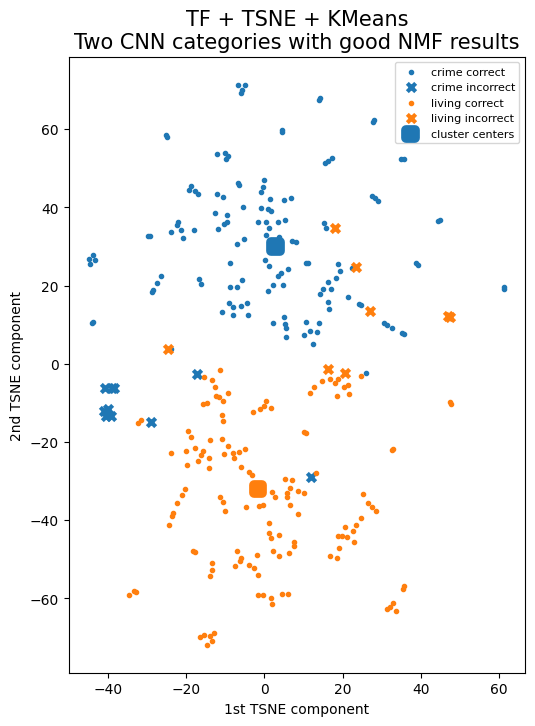

In [11]:
plot_and_save_clustering_results(km_results, km.cluster_centers_, n_groups=2, 
                                 kmeans_or_gmm=True, cnn_or_fox=True, 
                                 top_title='TF + TSNE + KMeans', bottom_title='Two CNN categories with good NMF results')

Doing the same thing with GMM.

In [12]:
gm = GaussianMixture(n_components=2, init_params='kmeans', random_state=rs, 
                     covariance_type='diag')
gm_results=gm.fit_predict(X_embedded)
res_table=results_table(dataloc.index, gm_results, nmf_or_clustering=False)
res_table

cluster         1    0
actual_topic          
cnn_living    139    9
cnn_crime      10  138

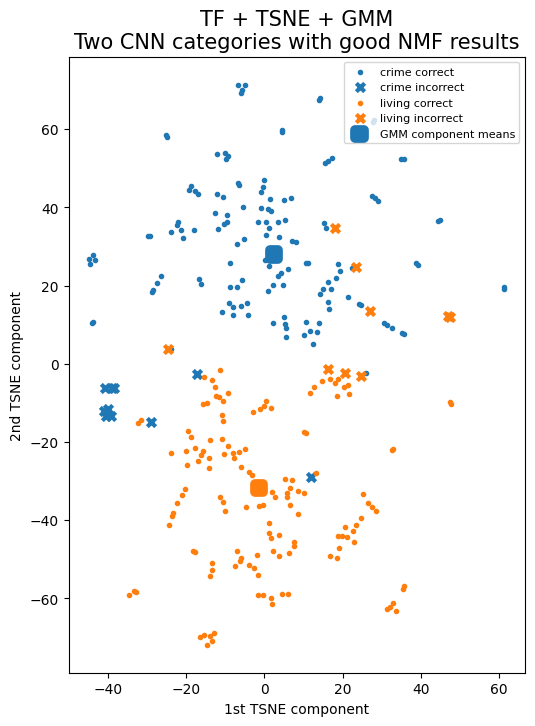

In [13]:
plot_and_save_clustering_results(gm_results, gm.means_, n_groups=2, 
                                 kmeans_or_gmm=False, cnn_or_fox=True, 
                                 top_title='TF + TSNE + GMM', bottom_title='Two CNN categories with good NMF results')

Overall, in this example TSNE+Clustering achieved better results than NMF on TF, but worse results than NMF on TF-IDF. K-means achieved slightly better results than GMM. 

### difficult 2-class cnn split

In this subsection, data from `cnn_crime` and `cnn_politics` is used. For this data, using NMF on TF-IDF data (see below) achieved accuracy of 0.641, which is a relatively bad result comparing to other two-topic splits of CNN data. NMF on TF data achieved a lower accuracy of 0.503.

Here, TSNE+Clustering achieved much better results than NMF, GMM clustring achieved slightly better results than K-means.

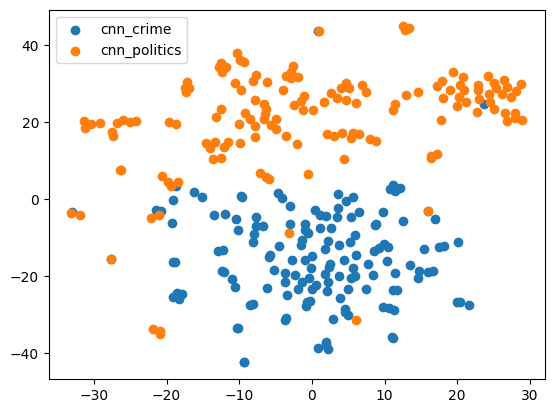

In [14]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('tsne', TSNE(n_components=2, init='random', random_state=rs, metric='cosine', method='exact', 
                            perplexity=20, n_jobs=-1))])

dataloc=pd.concat(data.loc[['cnn_crime', 'cnn_politics']].tolist())
X_embedded=pipe.fit_transform(dataloc)

fig, ax = plt.subplots()
ax.scatter(*X_embedded[:cnn_min_files_in_folder].T,label=dataloc.index[0].split('.')[0])
ax.scatter(*X_embedded[cnn_min_files_in_folder:].T,label=dataloc.index[-1].split('.')[0])
ax.legend();

In [15]:
km = KMeans(n_clusters=2, random_state=rs, n_init='auto')
km_results=km.fit_predict(X_embedded)
res_table=results_table(dataloc.index, km_results, nmf_or_clustering=False)
res_table

cluster         1    0
actual_topic          
cnn_crime     145    3
cnn_politics   14  134

In [16]:
evaluate(km_results, n_classes=2, cnn_or_fox=True)

0.9425675675675675

In [17]:
plot_and_save_confusion_matrix(res_table, top_title='TF + TSNE + KMeans', bottom_title='Two CNN categories with poor NMF results')

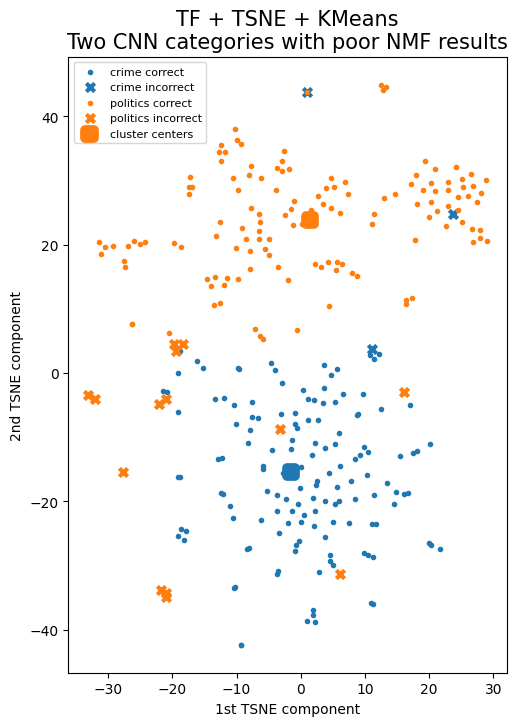

In [18]:
plot_and_save_clustering_results_reverse(km_results, km.cluster_centers_, n_groups=2, 
                                 kmeans_or_gmm=True, cnn_or_fox=True, 
                                 top_title='TF + TSNE + KMeans', bottom_title='Two CNN categories with poor NMF results')

In [19]:
gm = GaussianMixture(n_components=2, init_params='kmeans', random_state=rs, 
                     covariance_type='tied')
gm_results=gm.fit_predict(X_embedded)
res_table=results_table(dataloc.index, gm_results, nmf_or_clustering=False)
res_table

cluster         1    0
actual_topic          
cnn_crime     145    3
cnn_politics   11  137

In [20]:
evaluate(gm_results, n_classes=2, cnn_or_fox=True)

0.9527027027027027

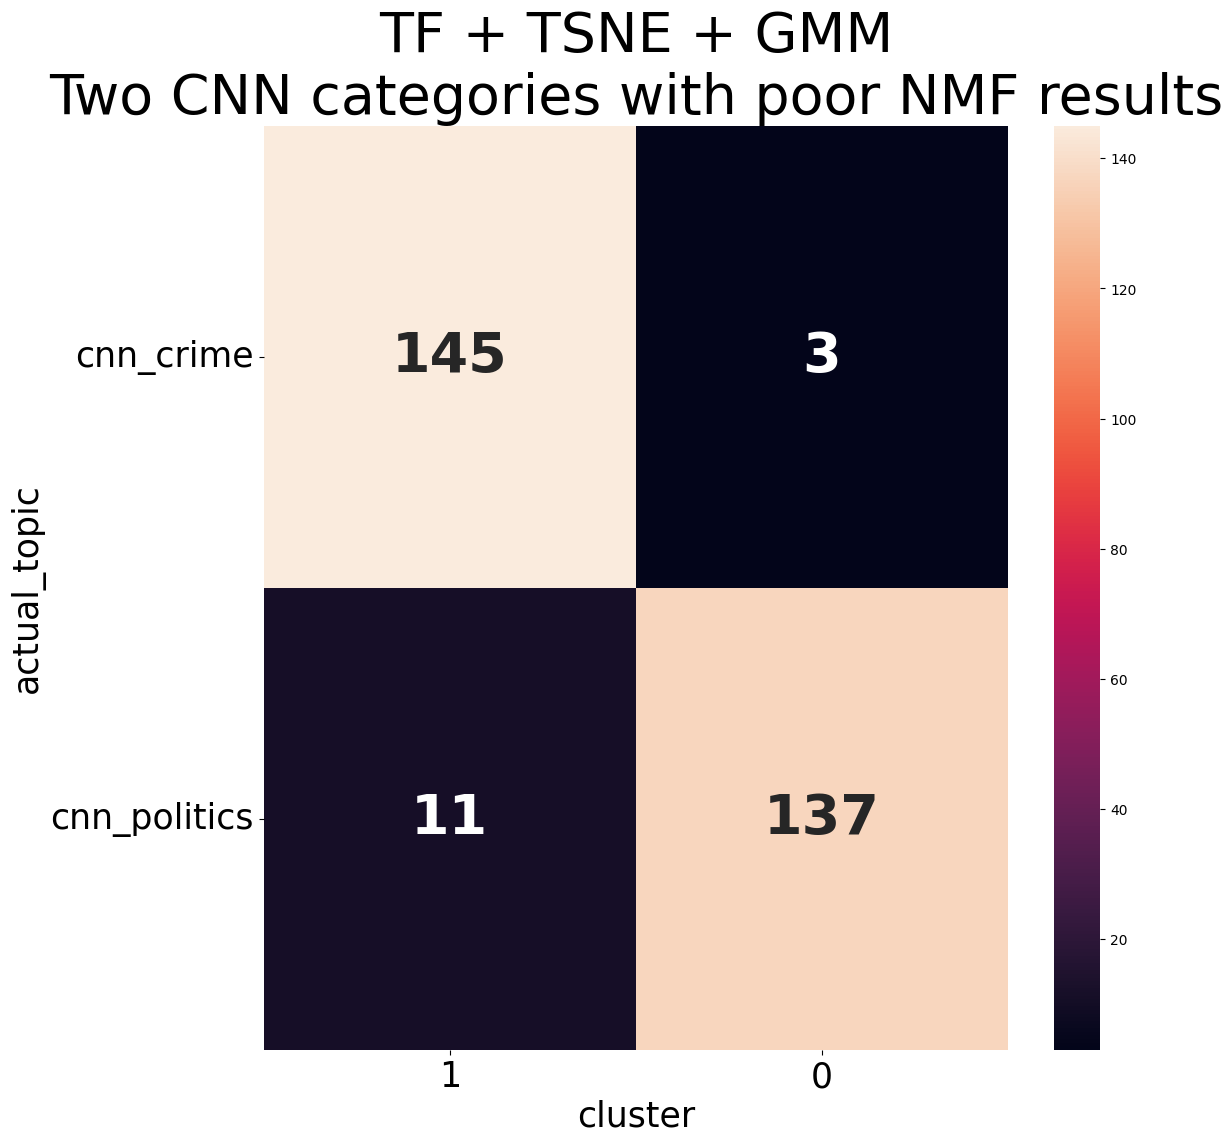

In [21]:
plot_and_save_confusion_matrix(res_table, top_title='TF + TSNE + GMM', bottom_title='Two CNN categories with poor NMF results')

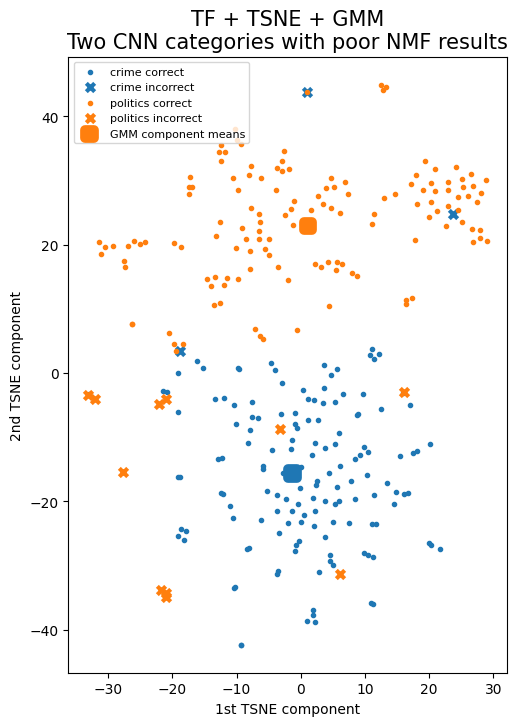

In [22]:
plot_and_save_clustering_results_reverse(gm_results, gm.means_, n_groups=2, 
                                 kmeans_or_gmm=False, cnn_or_fox=True, 
                                 top_title='TF + TSNE + GMM', bottom_title='Two CNN categories with poor NMF results')

### the most difficult 2-class split cnn

In this subsection, data from `cnn_entertainment` and `cnn_travel` is used. For this data, using NMF on TF-IDF data (see below) achieved accuracy of 0.567, which is the worst result comparing to other two-topic splits of CNN data. NMF on TF data achieved a lower accuracy of 0.506.

Here, TSNE+Clustering achieved much better results than NMF, GMM clustring achieved better results than K-means.

In [23]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('tsne', TSNE(n_components=2, init='random', random_state=rs, metric='cosine', method='exact', 
                            perplexity=50, n_jobs=-1))])

dataloc=pd.concat(data.loc[['cnn_entertainment', 'cnn_travel']].tolist())
X_embedded=pipe.fit_transform(dataloc)

fig, ax = plt.subplots()
ax.scatter(*X_embedded[:cnn_min_files_in_folder].T,label=dataloc.index[0].split('.')[0])
ax.scatter(*X_embedded[cnn_min_files_in_folder:].T,label=dataloc.index[-1].split('.')[0])
ax.legend();

In [24]:
km = KMeans(n_clusters=2, random_state=rs, n_init='auto')
km_results=km.fit_predict(X_embedded)
res_table=results_table(dataloc.index, km_results, nmf_or_clustering=False)
res_table

cluster              1    0
actual_topic               
cnn_entertainment  138   10
cnn_travel          38  110

In [25]:
evaluate(km_results, n_classes=2, cnn_or_fox=True)

0.8378378378378378

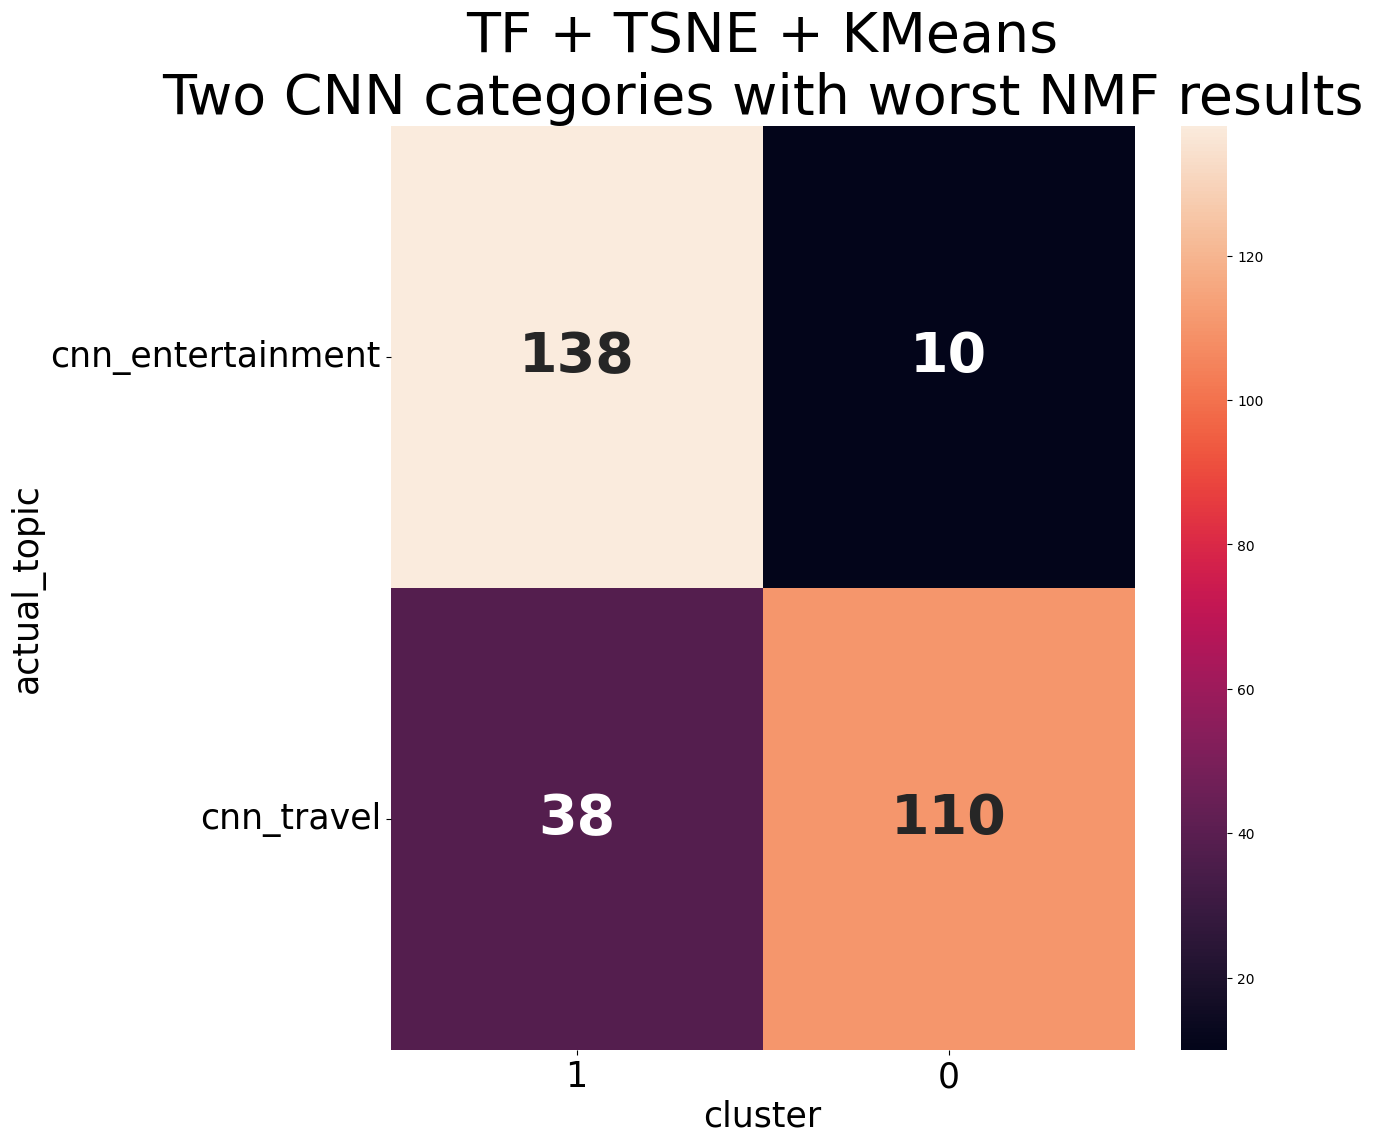

In [26]:
plot_and_save_confusion_matrix(res_table, top_title='TF + TSNE + KMeans', bottom_title='Two CNN categories with worst NMF results')

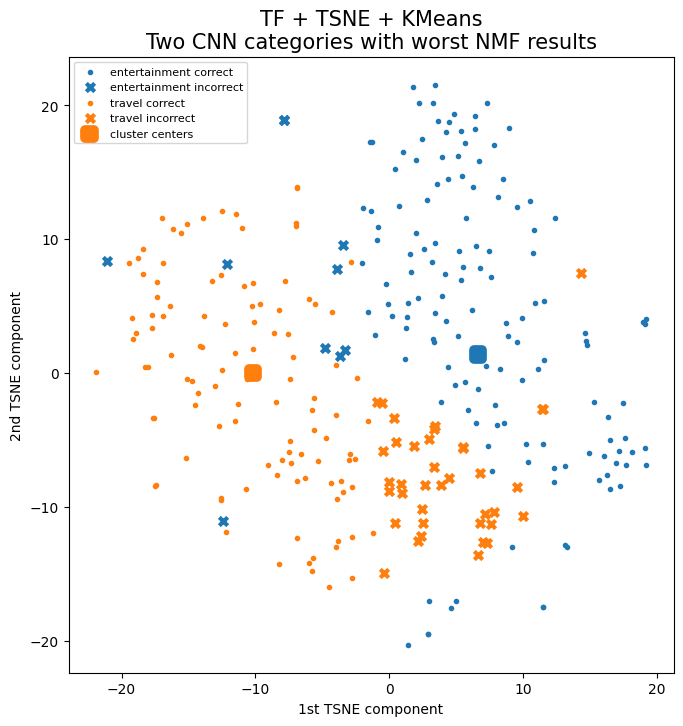

In [27]:
plot_and_save_clustering_results_reverse(km_results, km.cluster_centers_, n_groups=2, 
                                 kmeans_or_gmm=True, cnn_or_fox=True, 
                                 top_title='TF + TSNE + KMeans', bottom_title='Two CNN categories with worst NMF results')

In [28]:
gm = GaussianMixture(n_components=2, init_params='kmeans', random_state=rs, 
                     covariance_type='tied')
gm_results=gm.fit_predict(X_embedded)
res_table=results_table(dataloc.index, gm_results, nmf_or_clustering=False)
res_table

cluster              1    0
actual_topic               
cnn_entertainment  135   13
cnn_travel          25  123

In [29]:
evaluate(gm_results, n_classes=2, cnn_or_fox=True)

0.8716216216216216

In [30]:
plot_and_save_clustering_results_reverse(gm_results, gm.means_, n_groups=2, 
                                 kmeans_or_gmm=False, cnn_or_fox=True, 
                                 top_title='TF + TSNE + GMM', bottom_title='Two CNN categories with worst NMF results')

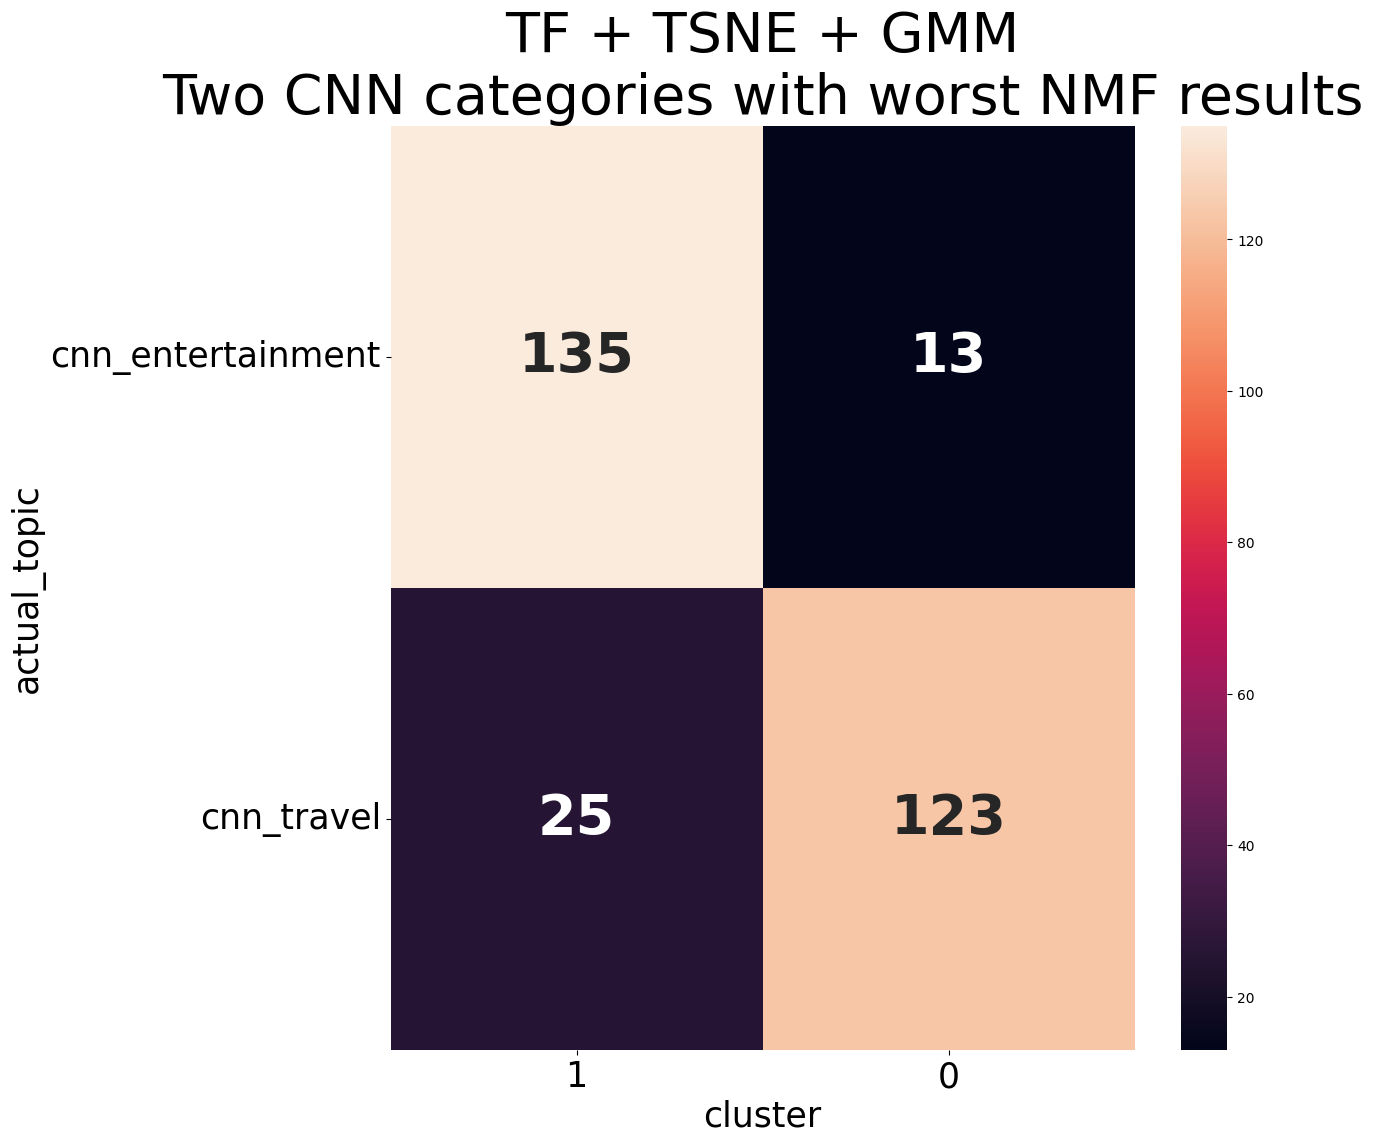

In [31]:
plot_and_save_confusion_matrix(res_table, top_title='TF + TSNE + GMM', bottom_title='Two CNN categories with worst NMF results')

### the most difficult 3-class split fox

In this subsection, data from `foxnews_health`, `foxnews_sports` and `foxnews_travel` is used. For this data, using NMF on TF-IDF data (see below) achieved accuracy of 0.558, which is the worst result comparing to other three-topic splits of FOX News data. On the other hand, NMF on TF data achieved accuracy of 0.889.

Here, TSNE+Clustering achieved much better results than NMF, GMM clustring achieved slightly better results than K-means.

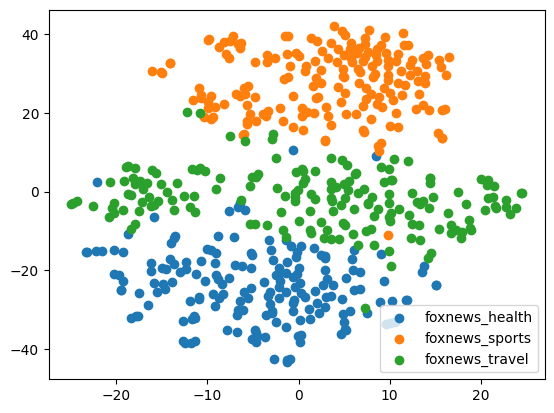

In [32]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('tsne', TSNE(n_components=2, init='random', random_state=rs, metric='cosine', method='exact', 
                            perplexity=50, n_jobs=-1))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_sports', 'foxnews_travel']].tolist())
X_embedded=pipe.fit_transform(dataloc)

fig, ax = plt.subplots()
ax.scatter(*X_embedded[:fox_min_files_in_folder].T,label=dataloc.index[0].split('.')[0])
ax.scatter(*X_embedded[fox_min_files_in_folder:2*fox_min_files_in_folder].T,
           label=dataloc.index[fox_min_files_in_folder].split('.')[0])
ax.scatter(*X_embedded[2*fox_min_files_in_folder:].T,label=dataloc.index[-1].split('.')[0])
ax.legend();

In [33]:
km = KMeans(n_clusters=3, random_state=rs, n_init='auto')
km_results=km.fit_predict(X_embedded)
res_table=results_table(dataloc.index, km_results, nmf_or_clustering=False)
res_table

cluster           1    2    0
actual_topic                 
foxnews_sports  174    4    0
foxnews_travel    5  170    3
foxnews_health    0   17  161

In [34]:
evaluate(km_results, n_classes=3, cnn_or_fox=False)

0.9456928838951311

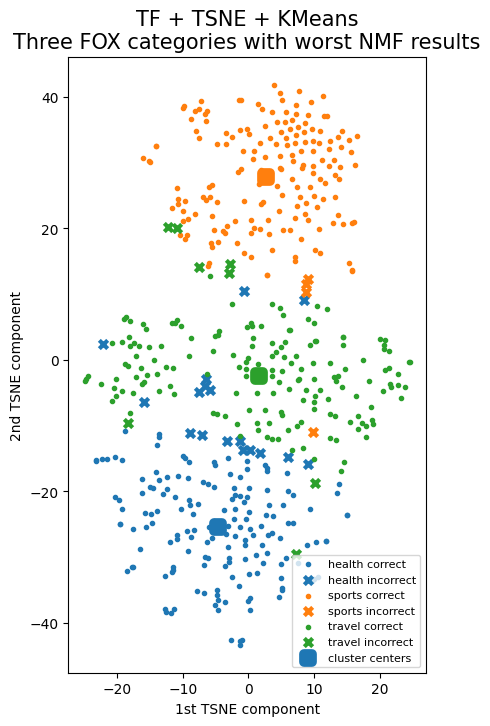

In [35]:
plot_and_save_clustering_results(km_results, km.cluster_centers_, n_groups=3, 
                                 kmeans_or_gmm=True, cnn_or_fox=False, 
                                 top_title='TF + TSNE + KMeans', bottom_title='Three FOX categories with worst NMF results')

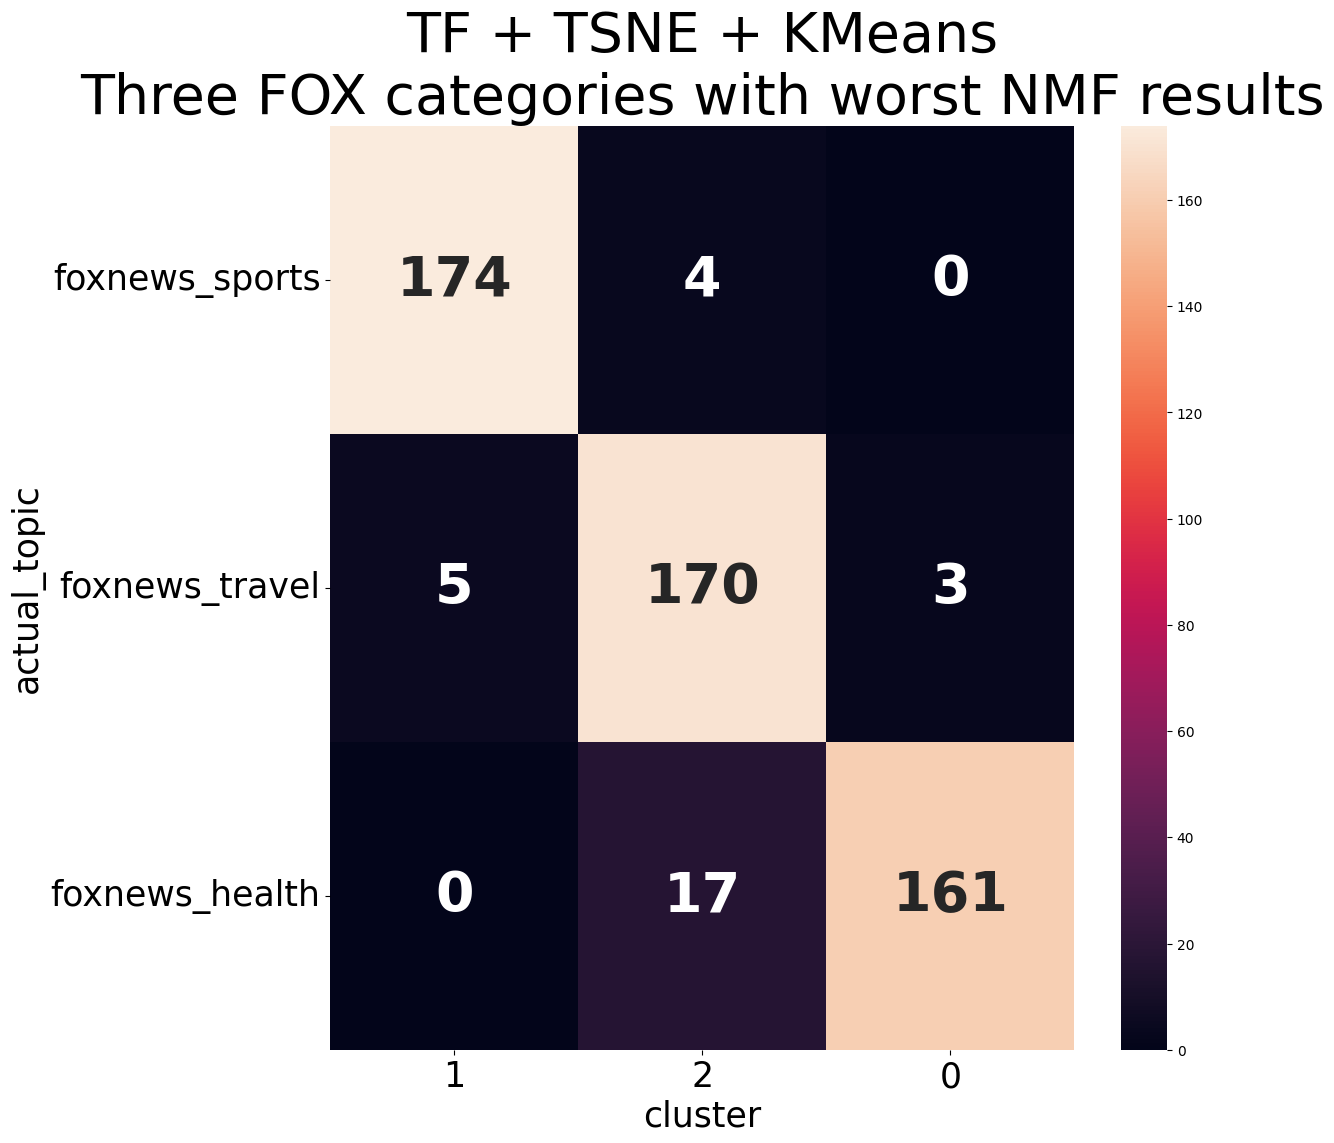

In [36]:
plot_and_save_confusion_matrix(res_table, 
                               top_title='TF + TSNE + KMeans', bottom_title='Three FOX categories with worst NMF results')

In [37]:
gm = GaussianMixture(n_components=3, init_params='kmeans', random_state=rs, 
                     covariance_type='full')
gm_results=gm.fit_predict(X_embedded)
res_table=results_table(dataloc.index, gm_results, nmf_or_clustering=False)
res_table

cluster           1    2    0
actual_topic                 
foxnews_sports  176    2    0
foxnews_travel    6  170    2
foxnews_health    0   14  164

In [38]:
evaluate(gm_results, n_classes=3, cnn_or_fox=False)

0.9550561797752809

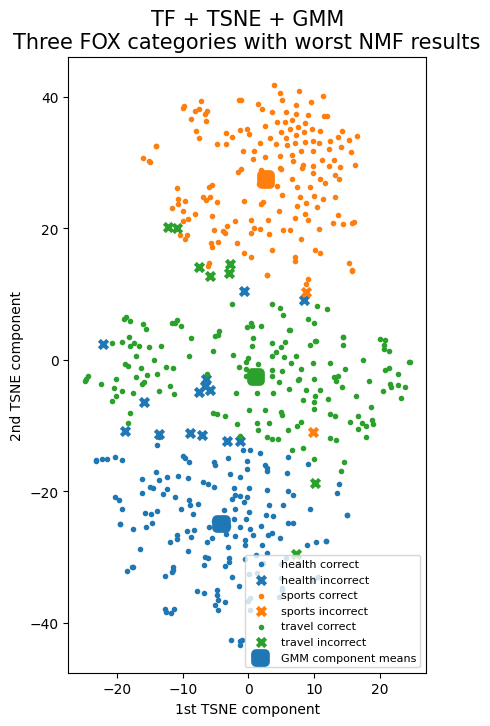

In [39]:
plot_and_save_clustering_results(gm_results, gm.means_, n_groups=3, 
                                 kmeans_or_gmm=False, cnn_or_fox=False, 
                                 top_title='TF + TSNE + GMM', bottom_title='Three FOX categories with worst NMF results')

In [40]:
plot_and_save_confusion_matrix(res_table, 
                               top_title='TF + TSNE + GMM', bottom_title='Three FOX categories with worst NMF results')

### all 4 fox

In this subsection, data from all 4 FOX news categories is used. For this data, using NMF on TF-IDF data (see below) achieved accuracy of 0.823. 

Here, due to a higher number of classes, TSNE+Clustering was attempted in both 2 and 3 dimensions. Only using 3-dimensional TSNE and GMM produces results similar to NMF, with no real improvement.

#### 2d

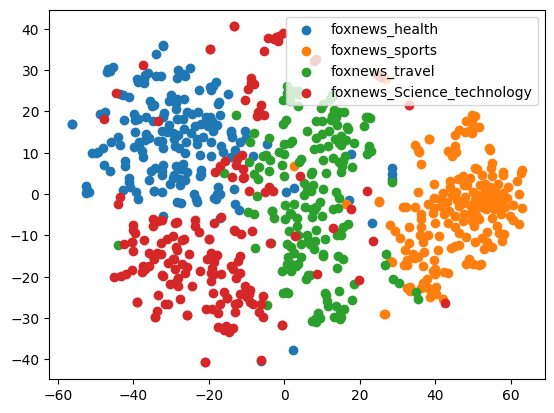

In [41]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('tsne', TSNE(n_components=2, init='random', random_state=rs, metric='cosine', method='exact', 
                            perplexity=40, n_jobs=-1))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_sports', 
                            'foxnews_travel', 'foxnews_Science_technology']].tolist())
X_embedded=pipe.fit_transform(dataloc)

fig, ax = plt.subplots()
ax.scatter(*X_embedded[:fox_min_files_in_folder].T,label=dataloc.index[0].split('.')[0])
ax.scatter(*X_embedded[fox_min_files_in_folder:2*fox_min_files_in_folder].T,
           label=dataloc.index[fox_min_files_in_folder].split('.')[0])
ax.scatter(*X_embedded[2*fox_min_files_in_folder:3*fox_min_files_in_folder].T,
           label=dataloc.index[2*fox_min_files_in_folder].split('.')[0])
ax.scatter(*X_embedded[3*fox_min_files_in_folder:].T,label=dataloc.index[-1].split('.')[0])
ax.legend();

In [42]:
km = KMeans(n_clusters=4, random_state=rs, n_init='auto')
km_results=km.fit_predict(X_embedded)
res_table=results_table(dataloc.index, km_results, nmf_or_clustering=False)
res_table

cluster                       1    3    2    0
actual_topic                                  
foxnews_sports              175    0    3    0
foxnews_health                4  158   11    5
foxnews_travel                7    2  115   54
foxnews_Science_technology    4   28   35  111

In [43]:
evaluate(km_results, n_classes=4, cnn_or_fox=False)

0.7851123595505618

In [44]:
results=km_results
centers_or_means=km.cluster_centers_
n_groups=4
kmeans_or_gmm=True
cnn_or_fox=False
top_title='TF + TSNE + KMeans'
bottom_title='All FOX categories'

fig, ax = plt.subplots(figsize=(8,8))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_aspect('equal','box')
if cnn_or_fox==True:
    class_size=cnn_min_files_in_folder
else :
    class_size=fox_min_files_in_folder

if kmeans_or_gmm==True:
    lbl='cluster centers'
else :
    lbl='GMM component means'

for i in [1, 2]:
    correct=(i*class_size) + np.where(results[i*class_size : (i+1)*class_size]==i)[0]
    incorrect=np.setdiff1d(np.arange(i*class_size, (i+1)*class_size), correct)
    ax.scatter(*X_embedded[correct].T,color=colors[i], marker='.', 
               label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' correct')
    ax.scatter(*X_embedded[incorrect].T,color=colors[i],marker='x', lw=3, 
               label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' incorrect')

for i in [0, 3]:
    correct=(i*class_size) + np.where(results[i*class_size : (i+1)*class_size]==n_groups-1-i)[0]
    incorrect=np.setdiff1d(np.arange(i*class_size, (i+1)*class_size), correct)
    ax.scatter(*X_embedded[correct].T,color=colors[i], marker='.', 
               label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' correct')
    ax.scatter(*X_embedded[incorrect].T,color=colors[i],marker='x', lw=3, 
               label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' incorrect')
    
ax.scatter(*centers_or_means.T,c=[colors[3],colors[1],colors[2],colors[0]],marker='s',lw=7, label=lbl)
ax.legend(fontsize=8)
ax.set_xlabel("1st TSNE component", fontsize=10);
ax.set_ylabel("2nd TSNE component", fontsize=10);
ax.set_title(top_title+'\n'+bottom_title, fontsize=15);
fig.savefig('pictures/clustering_'+top_title+' '+bottom_title+'.png',dpi=400, bbox_inches="tight");

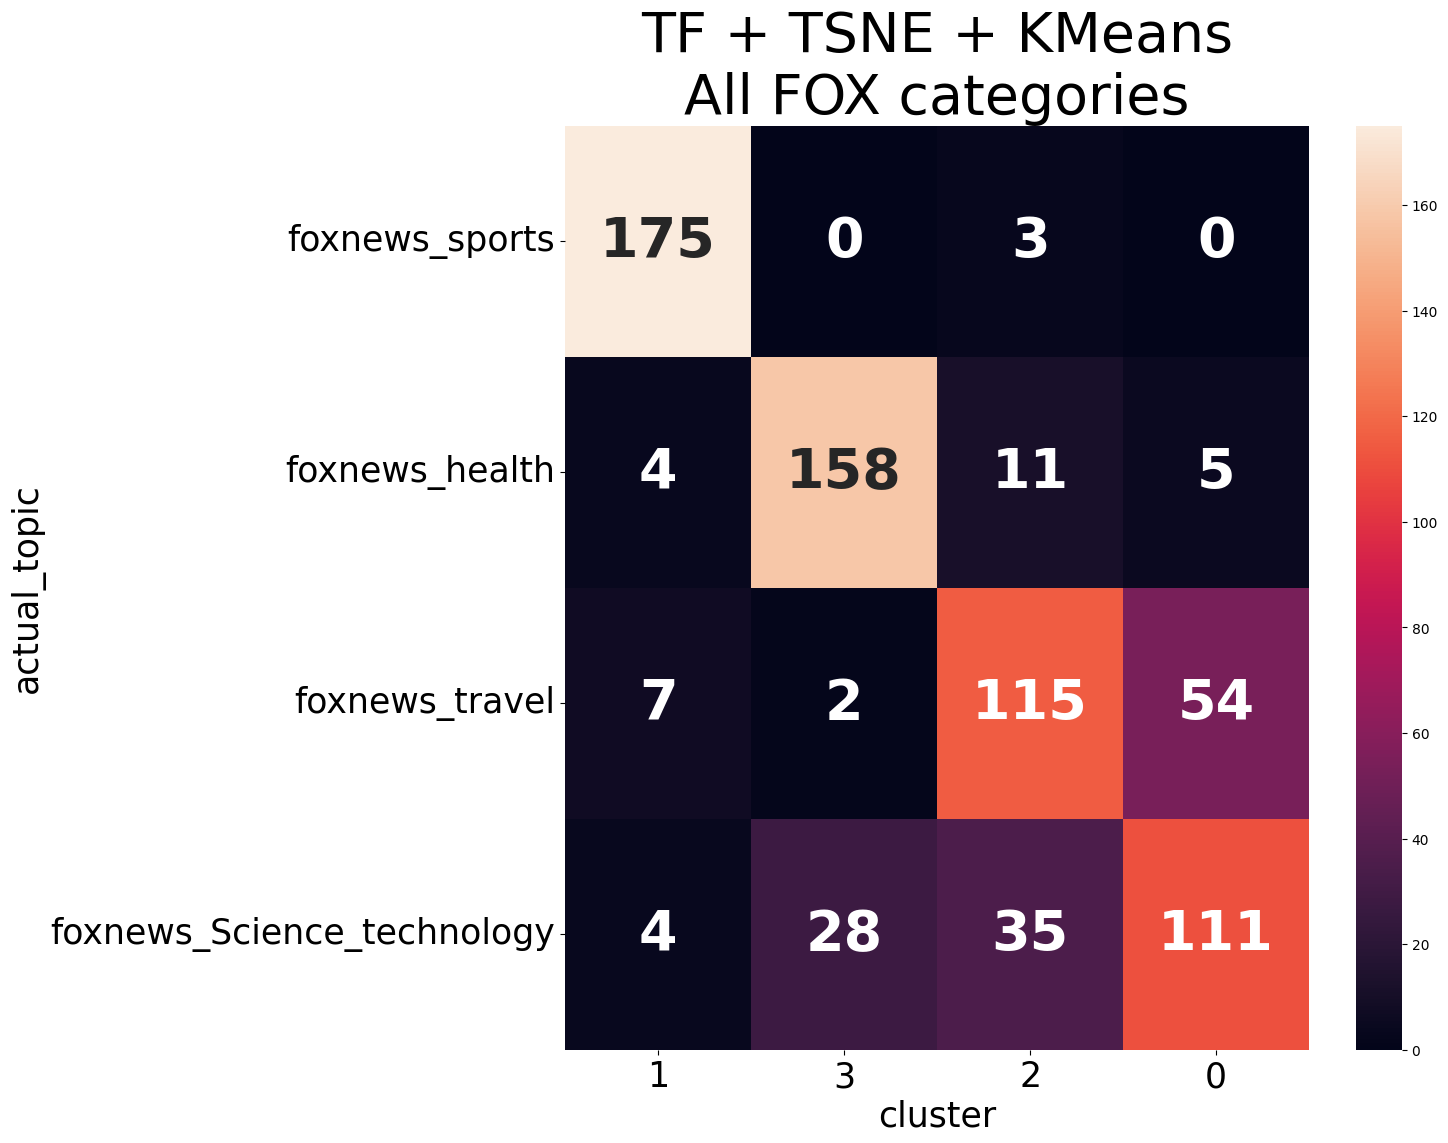

In [45]:
plot_and_save_confusion_matrix(res_table, 
                               top_title='TF + TSNE + KMeans', bottom_title='All FOX categories')

In [46]:
gm = GaussianMixture(n_components=4, init_params='kmeans', random_state=rs, 
                     covariance_type='full')
gm_results=gm.fit_predict(X_embedded)
res_table=results_table(dataloc.index, gm_results, nmf_or_clustering=False)
res_table

cluster                       1    3    2    0
actual_topic                                  
foxnews_sports              169    0    7    2
foxnews_health                0  160   15    3
foxnews_travel                6    2  124   46
foxnews_Science_technology    1   25   36  116

In [47]:
evaluate(gm_results, n_classes=4, cnn_or_fox=False)

0.7991573033707865

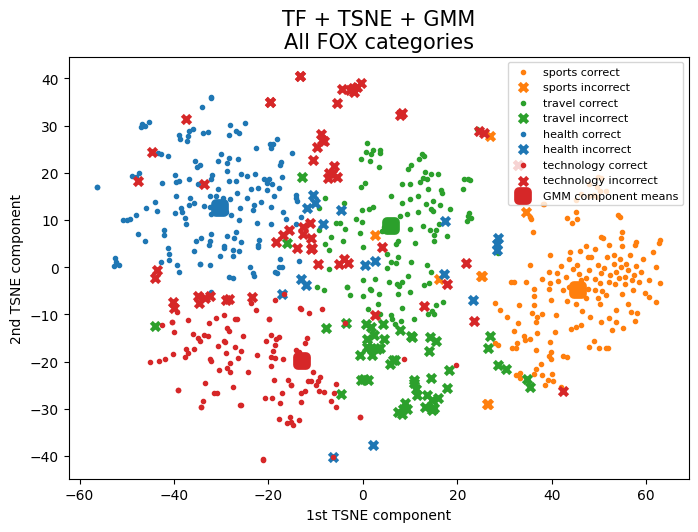

In [48]:
results=gm_results
centers_or_means=gm.means_
n_groups=4
kmeans_or_gmm=False
cnn_or_fox=False
top_title='TF + TSNE + GMM'
bottom_title='All FOX categories'

fig, ax = plt.subplots(figsize=(8,8))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_aspect('equal','box')
if cnn_or_fox==True:
    class_size=cnn_min_files_in_folder
else :
    class_size=fox_min_files_in_folder

if kmeans_or_gmm==True:
    lbl='cluster centers'
else :
    lbl='GMM component means'

for i in [1, 2]:
    correct=(i*class_size) + np.where(results[i*class_size : (i+1)*class_size]==i)[0]
    incorrect=np.setdiff1d(np.arange(i*class_size, (i+1)*class_size), correct)
    ax.scatter(*X_embedded[correct].T,color=colors[i], marker='.', 
               label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' correct')
    ax.scatter(*X_embedded[incorrect].T,color=colors[i],marker='x', lw=3, 
               label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' incorrect')

for i in [0, 3]:
    correct=(i*class_size) + np.where(results[i*class_size : (i+1)*class_size]==n_groups-1-i)[0]
    incorrect=np.setdiff1d(np.arange(i*class_size, (i+1)*class_size), correct)
    ax.scatter(*X_embedded[correct].T,color=colors[i], marker='.', 
               label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' correct')
    ax.scatter(*X_embedded[incorrect].T,color=colors[i],marker='x', lw=3, 
               label=dataloc.index[i*class_size].split('.')[0].split('_')[-1]+' incorrect')
    
ax.scatter(*centers_or_means.T,c=[colors[3],colors[1],colors[2],colors[0]],marker='s',lw=7, label=lbl)
ax.legend(fontsize=8)
ax.set_xlabel("1st TSNE component", fontsize=10);
ax.set_ylabel("2nd TSNE component", fontsize=10);
ax.set_title(top_title+'\n'+bottom_title, fontsize=15);
fig.savefig('pictures/clustering_'+top_title+' '+bottom_title+'.png',dpi=400, bbox_inches="tight");

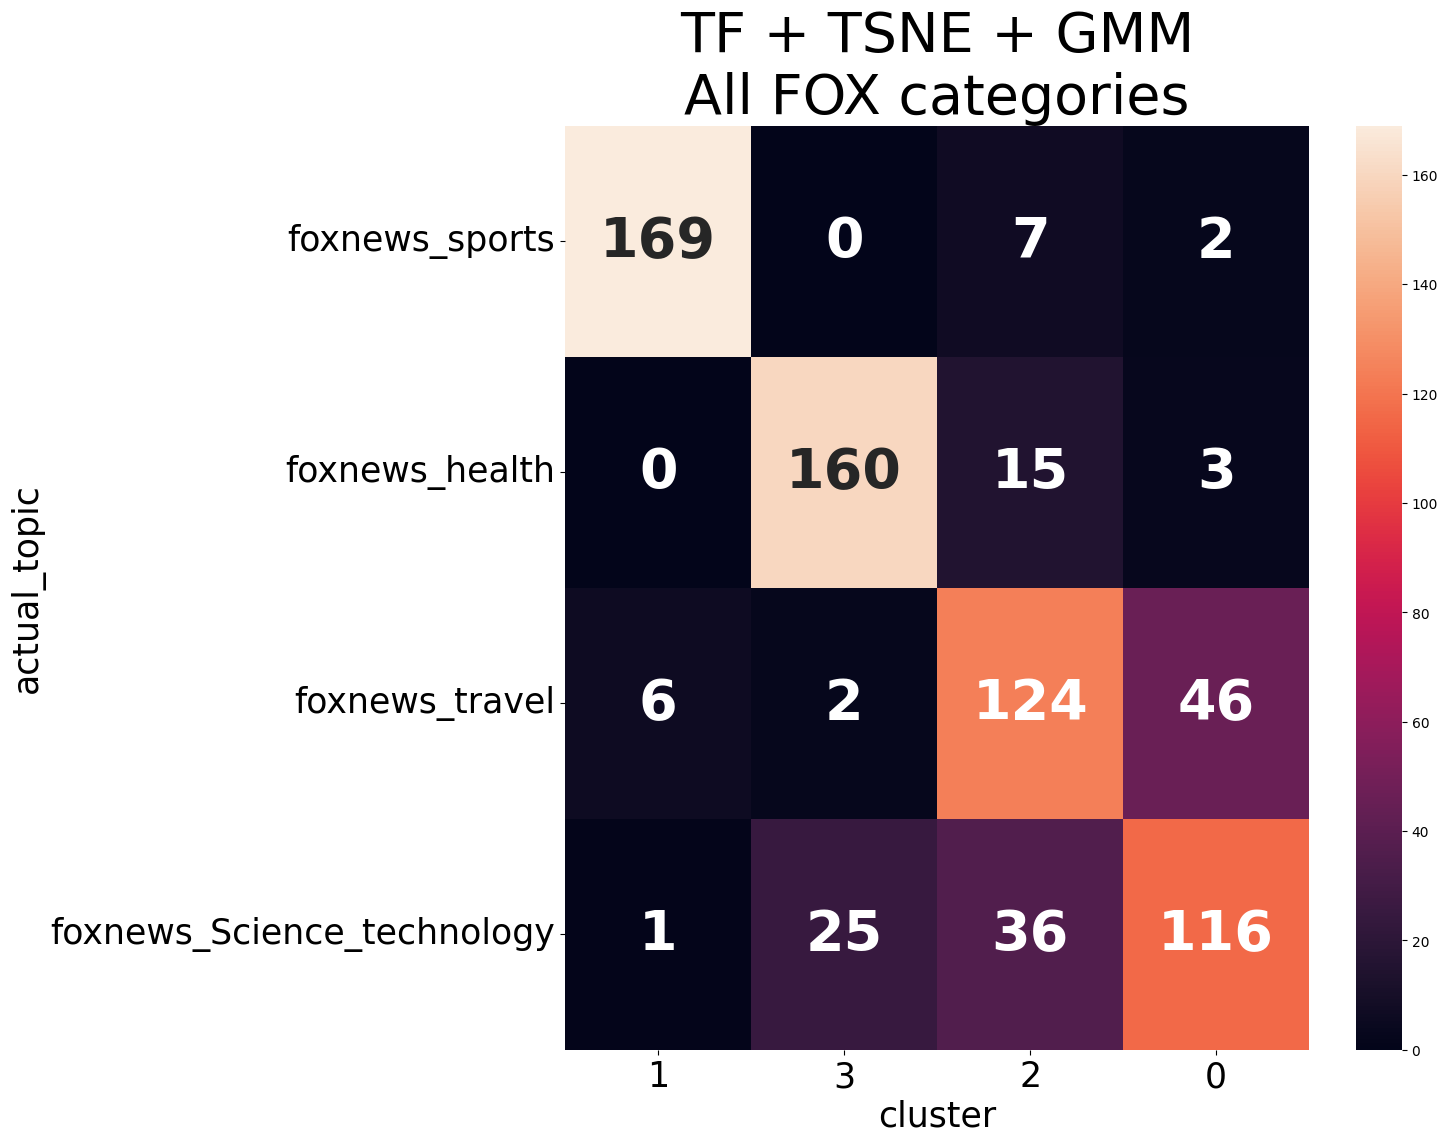

In [49]:
plot_and_save_confusion_matrix(res_table, 
                               top_title='TF + TSNE + GMM', bottom_title='All FOX categories')

#### 3d

In [50]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('tsne', TSNE(n_components=3, init='random', random_state=rs, metric='cosine', method='exact', 
                            perplexity=40, n_jobs=-1))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_sports', 
                            'foxnews_travel', 'foxnews_Science_technology']].tolist())
X_embedded=pipe.fit_transform(dataloc)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(*X_embedded[:fox_min_files_in_folder].T,label=dataloc.index[0].split('.')[0])
ax.scatter(*X_embedded[fox_min_files_in_folder:2*fox_min_files_in_folder].T,
           label=dataloc.index[fox_min_files_in_folder].split('.')[0])
ax.scatter(*X_embedded[2*fox_min_files_in_folder:3*fox_min_files_in_folder].T,
           label=dataloc.index[2*fox_min_files_in_folder].split('.')[0])
ax.scatter(*X_embedded[3*fox_min_files_in_folder:].T,label=dataloc.index[-1].split('.')[0])
ax.legend();

In [51]:
km = KMeans(n_clusters=4, random_state=rs, n_init='auto')
km_results=km.fit_predict(X_embedded)
res_table=results_table(dataloc.index, km_results, nmf_or_clustering=False)
res_table

cluster                       3    1    2    0
actual_topic                                  
foxnews_sports              163    0    0   15
foxnews_health                2  139   24   13
foxnews_travel               13   18  132   15
foxnews_Science_technology   13   44   13  108

In [52]:
evaluate(km_results, n_classes=4, cnn_or_fox=False)

0.7612359550561798

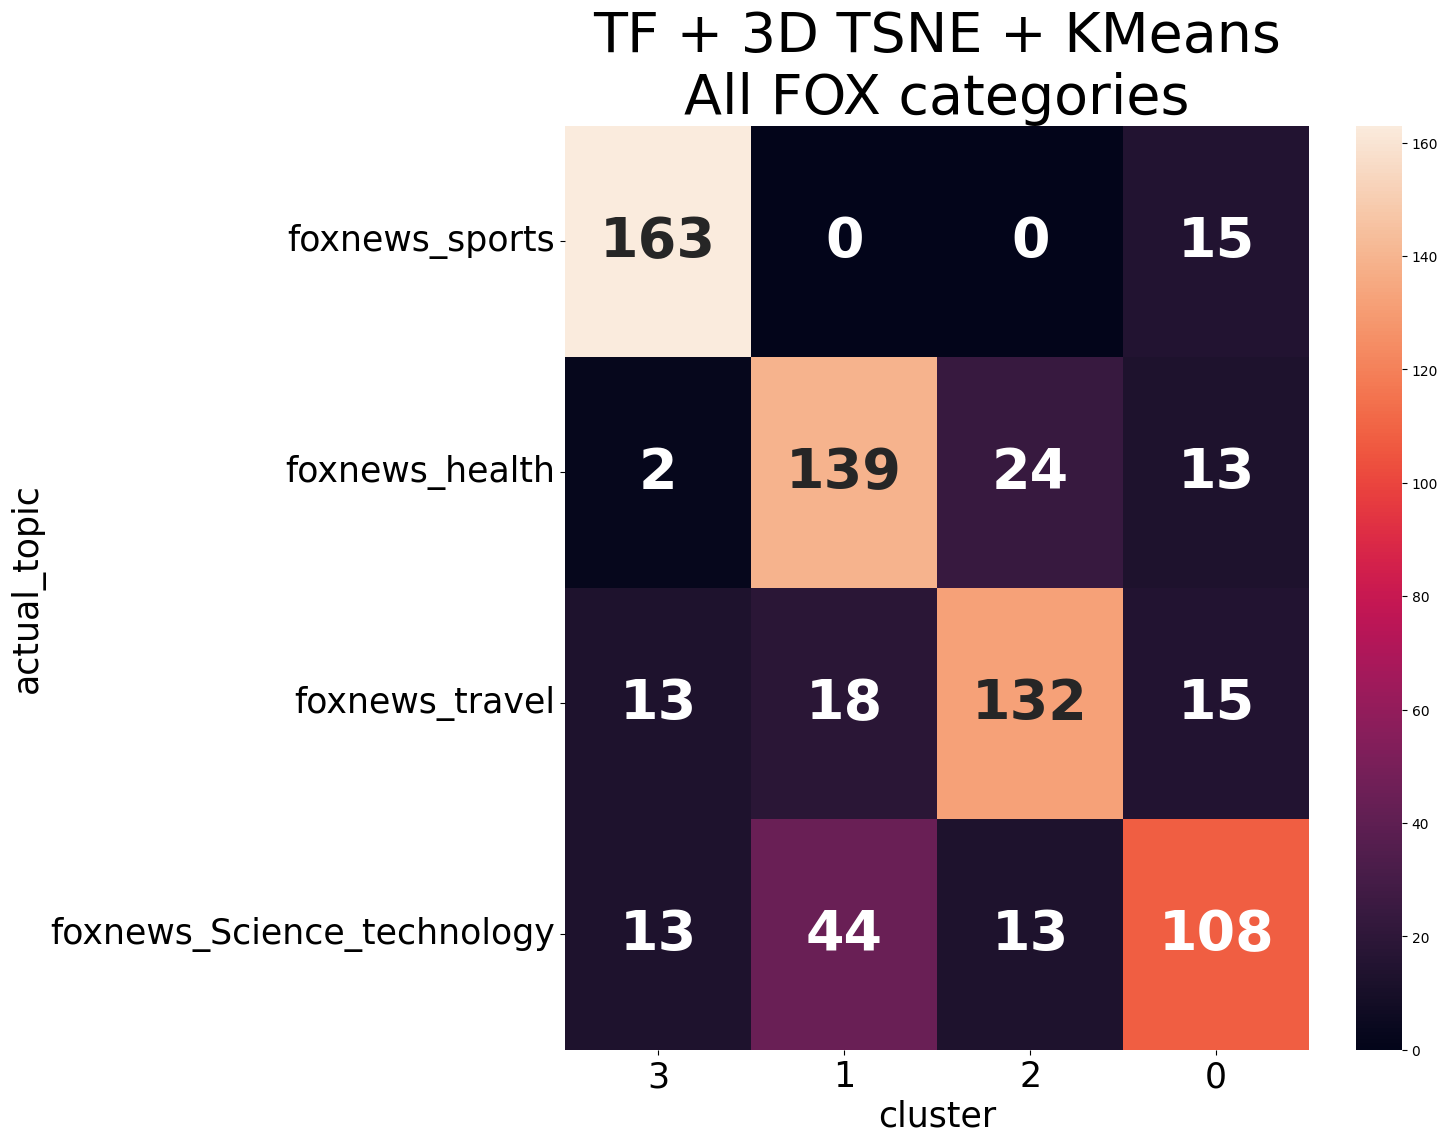

In [53]:
plot_and_save_confusion_matrix(res_table, 
                               top_title='TF + 3D TSNE + KMeans', bottom_title='All FOX categories')

In [54]:
gm = GaussianMixture(n_components=4, init_params='kmeans', random_state=rs, 
                     covariance_type='diag')
gm_results=gm.fit_predict(X_embedded)
res_table=results_table(dataloc.index, gm_results, nmf_or_clustering=False)
res_table

cluster                       3    0    1    2
actual_topic                                  
foxnews_sports              165   13    0    0
foxnews_Science_technology    5  155    7   11
foxnews_health                0   25  148    5
foxnews_travel                6   42    5  125

In [55]:
evaluate(gm_results, n_classes=4, cnn_or_fox=False)

0.8328651685393258

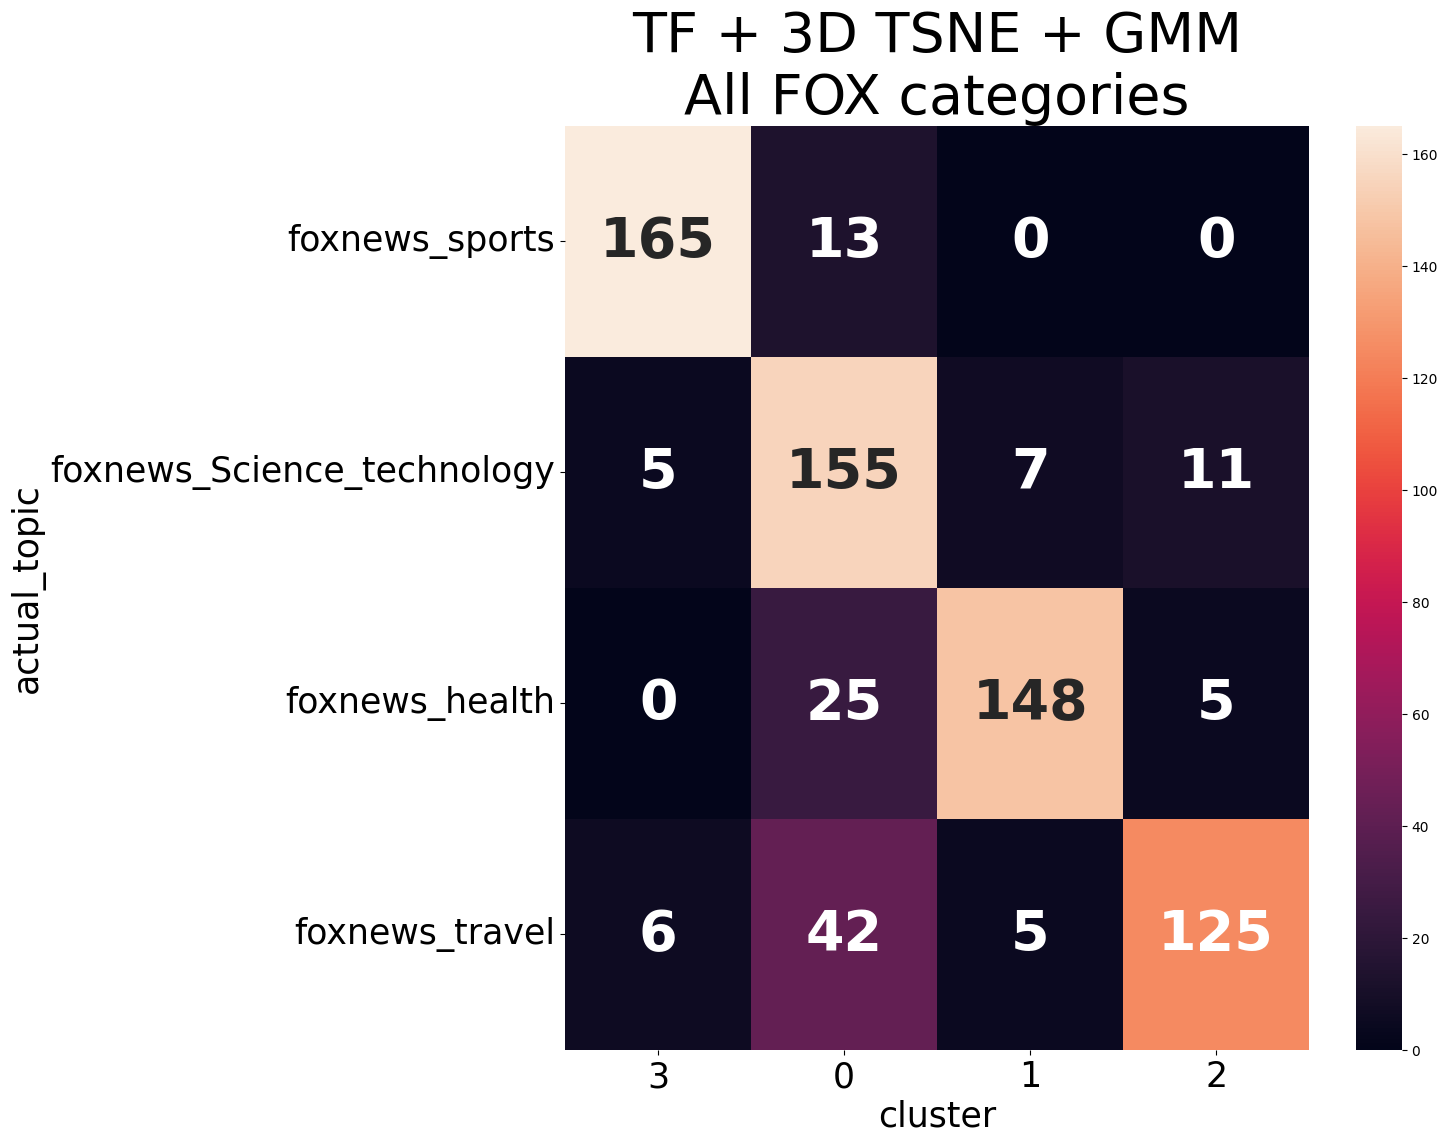

In [56]:
plot_and_save_confusion_matrix(res_table, 
                               top_title='TF + 3D TSNE + GMM', bottom_title='All FOX categories')

## TFIDF + TSNE

In this section, `term frequency - inverse document frequency (TF-IDF)` is used to encode text data. 

Here, in every subsection transforming and embedding the data is done via a similar pipeline.
```python
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('tsne', TSNE(n_components=2, init='random', random_state=rs, metric='cosine', 
                            method='exact', perplexity=40, n_jobs=-1))])
```
First, `TfidfVectorizer` is used to compute the TF-IDF for 1000 most common words, but only among those who are present in >1% and <95% of documents. Then, `TSNE` transforms the data down to `n_components` dimensions using cosine distance and random initialization with a fixed random state. The only hyperparameters changed from one subsection to another are `n_components` and `perplexity` for TSNE.

Then, the data is clustered via k-means and GMM:
```python
km = KMeans(n_clusters=2, random_state=rs, n_init='auto')
gm = GaussianMixture(n_components=2, init_params='kmeans', random_state=rs, 
                     covariance_type='diag')
```
`n_clusters` and `n_components` are equal to number of classes in the data sample.
The only other hyperparameter altered is `covariance_type` for `GaussianMixture`.

### 3-class split

In this subsection, data from `foxnews_health`, `foxnews_sports` and `foxnews_Science_technology` is used. For this data, using NMF on TF-IDF data (see below) achieved accuracy of 0.958.

Here, TSNE+Clustering achieved worse results than NMF, and 3-dimensional TSNE didn't improve on 2-dimensional.

#### 3d

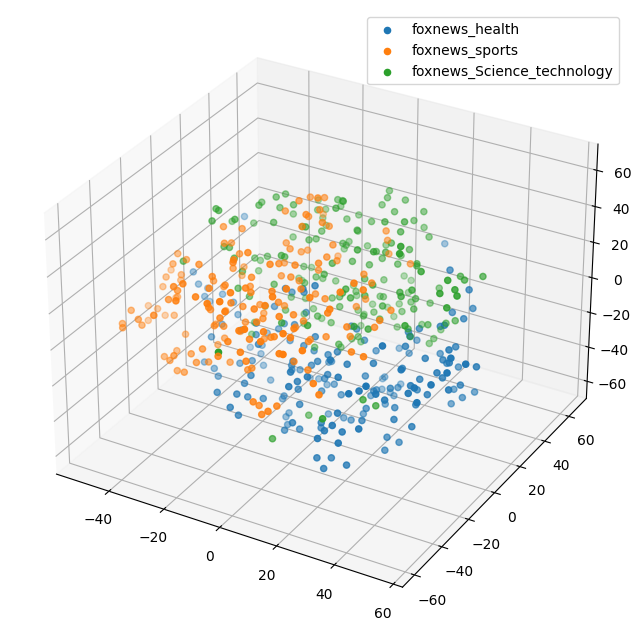

In [57]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('tsne', TSNE(n_components=3, init='random', random_state=rs, metric='cosine', method='exact', 
                            perplexity=40, n_jobs=-1))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_sports', 'foxnews_Science_technology']].tolist())
X_embedded=pipe.fit_transform(dataloc)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(*X_embedded[:fox_min_files_in_folder].T,label=dataloc.index[0].split('.')[0])
ax.scatter(*X_embedded[fox_min_files_in_folder:2*fox_min_files_in_folder].T,
           label=dataloc.index[fox_min_files_in_folder].split('.')[0])
ax.scatter(*X_embedded[2*fox_min_files_in_folder:].T,label=dataloc.index[-1].split('.')[0])
ax.legend();

In [58]:
km = KMeans(n_clusters=3, random_state=rs, n_init='auto')
km_results=km.fit_predict(X_embedded)
res_table=results_table(dataloc.index, km_results, nmf_or_clustering=False)
res_table

cluster                       1    0    2
actual_topic                             
foxnews_sports              172    0    6
foxnews_health                6  154   18
foxnews_Science_technology   13   16  149

In [59]:
evaluate(km_results, n_classes=3, cnn_or_fox=False)

0.8895131086142322

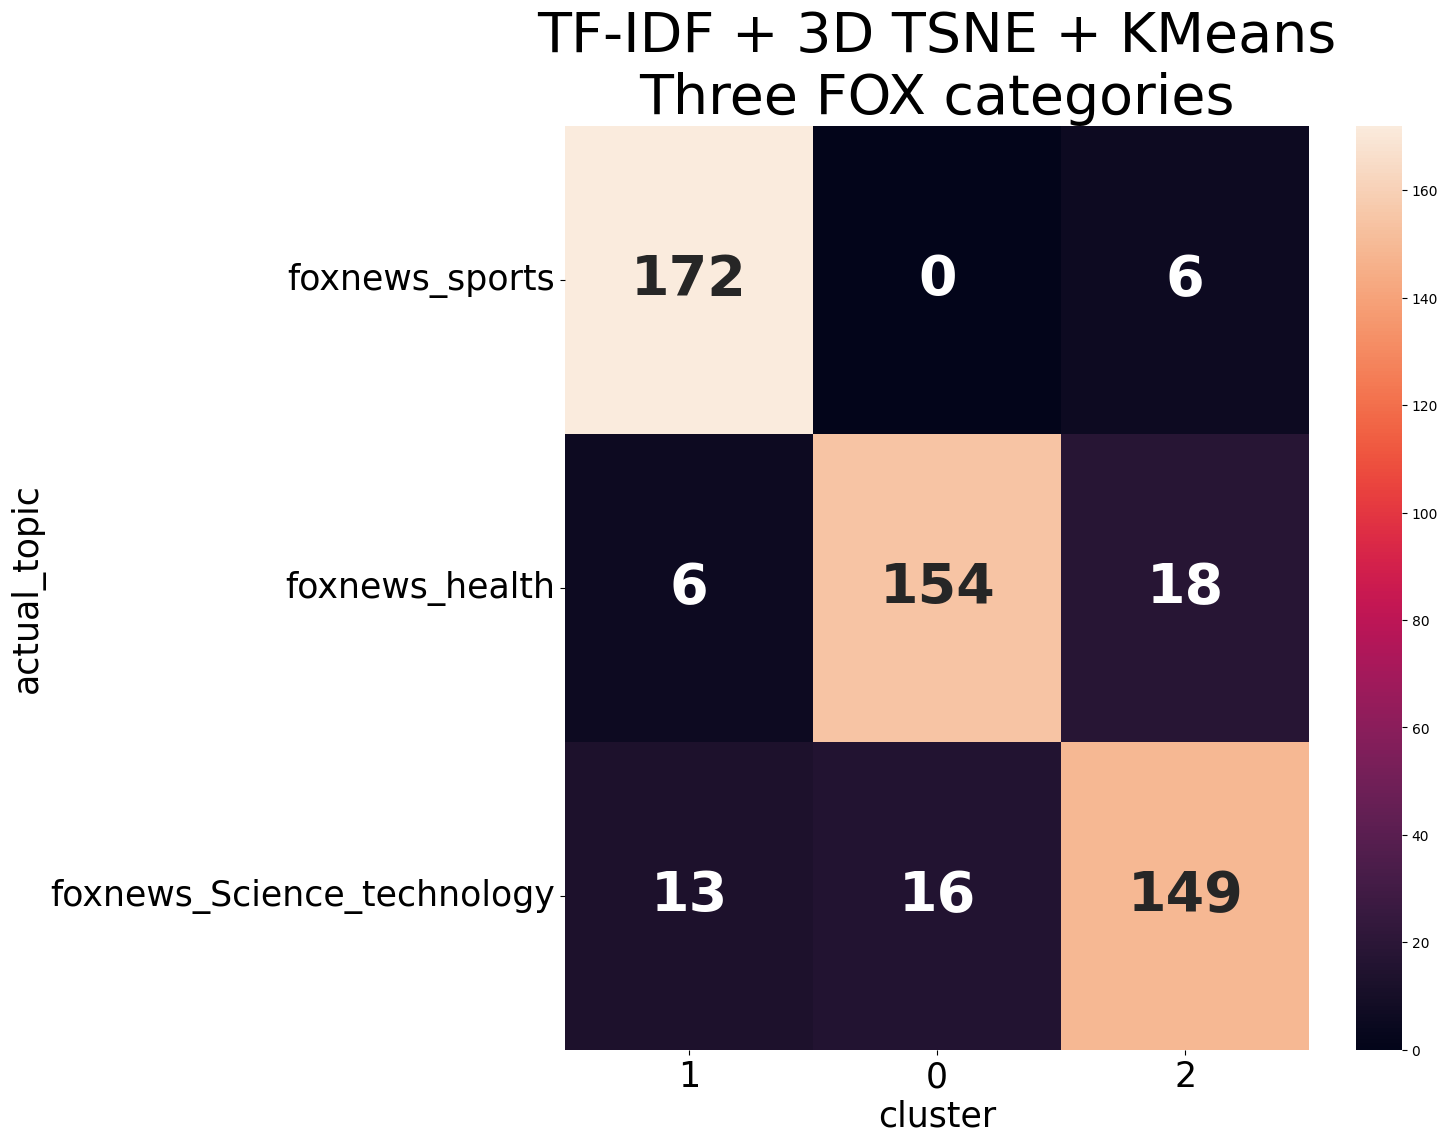

In [60]:
plot_and_save_confusion_matrix(res_table, top_title='TF-IDF + 3D TSNE + KMeans', bottom_title='Three FOX categories')

#### 2d

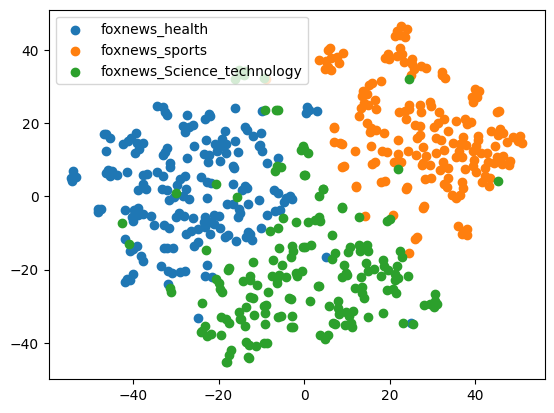

In [61]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('tsne', TSNE(n_components=2, init='random', random_state=rs, metric='cosine', method='exact', 
                            perplexity=40, n_jobs=-1))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_sports', 'foxnews_Science_technology']].tolist())
X_embedded=pipe.fit_transform(dataloc)

fig, ax = plt.subplots()
ax.scatter(*X_embedded[:fox_min_files_in_folder].T,label=dataloc.index[0].split('.')[0])
ax.scatter(*X_embedded[fox_min_files_in_folder:2*fox_min_files_in_folder].T,
           label=dataloc.index[fox_min_files_in_folder].split('.')[0])
ax.scatter(*X_embedded[2*fox_min_files_in_folder:].T,label=dataloc.index[-1].split('.')[0])
ax.legend();

In [62]:
km = KMeans(n_clusters=3, random_state=rs, n_init='auto')
km_results=km.fit_predict(X_embedded)
res_table=results_table(dataloc.index, km_results, nmf_or_clustering=False)
res_table

cluster                       1    0    2
actual_topic                             
foxnews_sports              173    1    4
foxnews_health                4  167    7
foxnews_Science_technology    7   23  148

In [63]:
evaluate(km_results, n_classes=3, cnn_or_fox=False)

0.9138576779026217

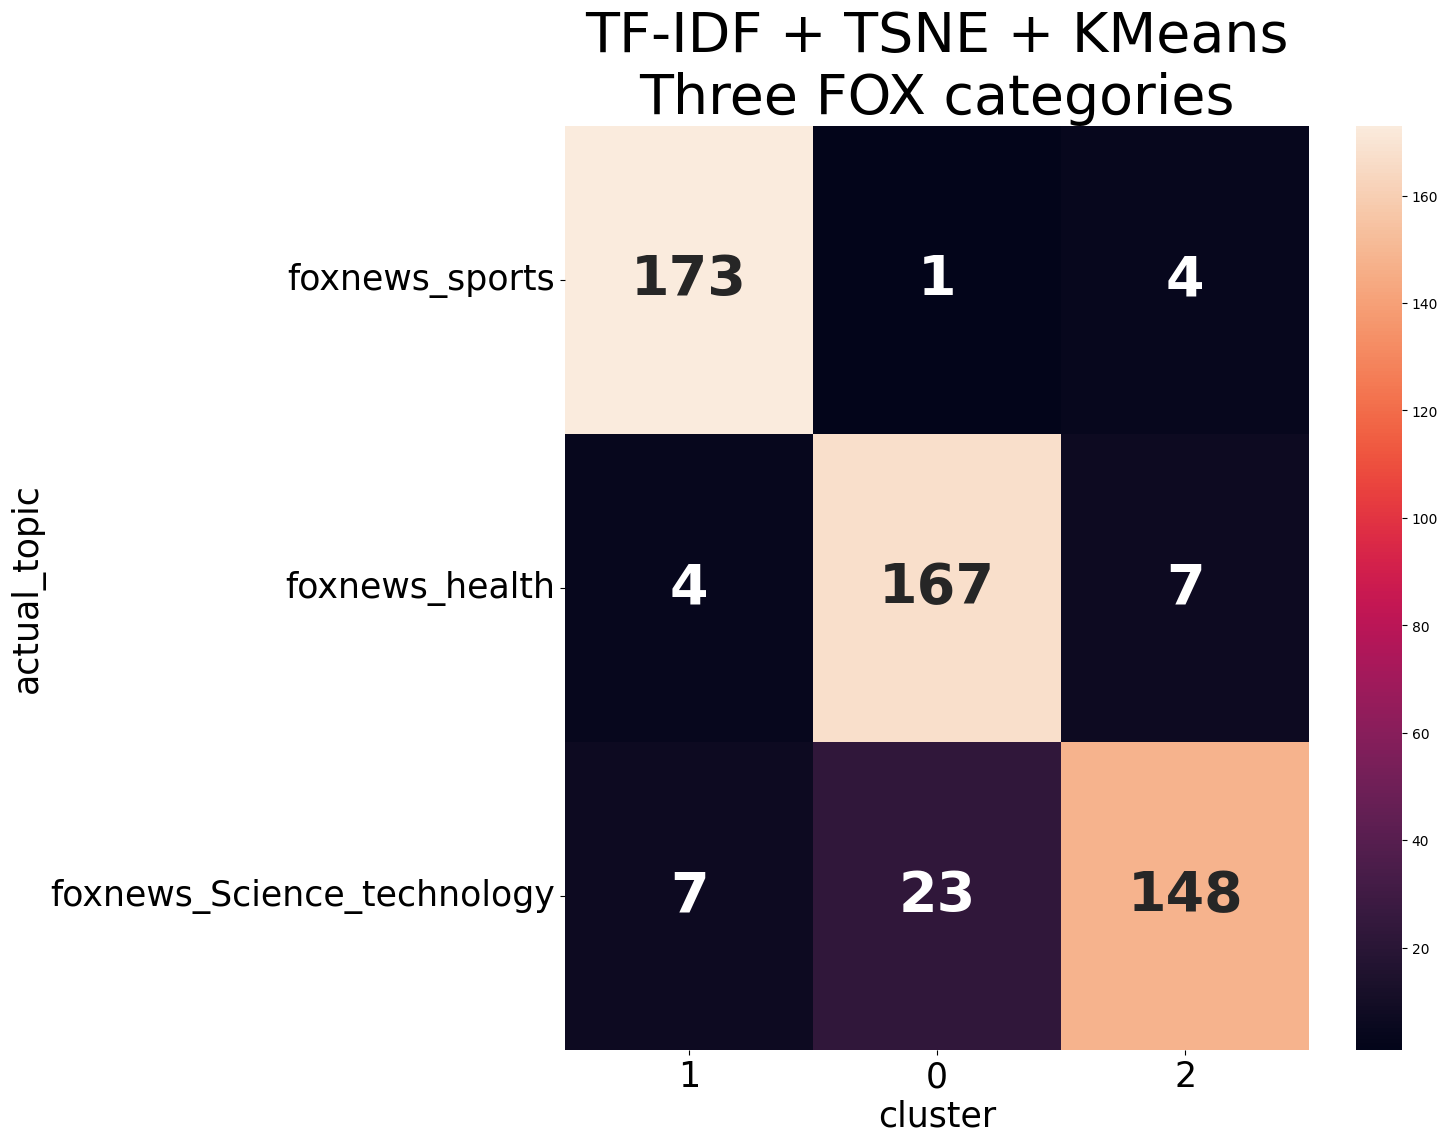

In [64]:
plot_and_save_confusion_matrix(res_table, top_title='TF-IDF + TSNE + KMeans', bottom_title='Three FOX categories')

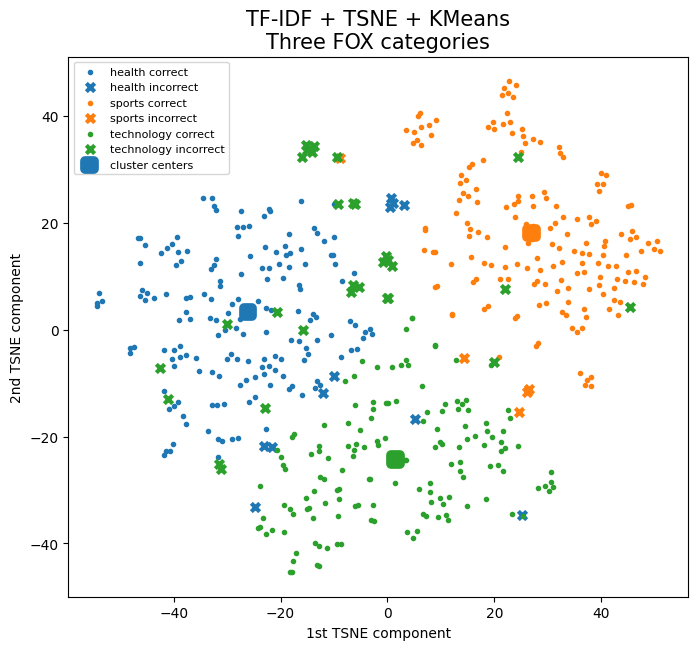

In [65]:
plot_and_save_clustering_results(km_results, km.cluster_centers_, n_groups=3, 
                                 kmeans_or_gmm=True, cnn_or_fox=False, 
                                 top_title='TF-IDF + TSNE + KMeans', bottom_title='Three FOX categories')

In [66]:
gm = GaussianMixture(n_components=3, init_params='kmeans', random_state=rs, 
                     covariance_type='spherical')
gm_results=gm.fit_predict(X_embedded)
res_table=results_table(dataloc.index, gm_results, nmf_or_clustering=False)
res_table

cluster                       1    0    2
actual_topic                             
foxnews_sports              174    1    3
foxnews_health                4  169    5
foxnews_Science_technology    8   23  147

In [67]:
evaluate(gm_results, n_classes=3, cnn_or_fox=False)

0.9176029962546817

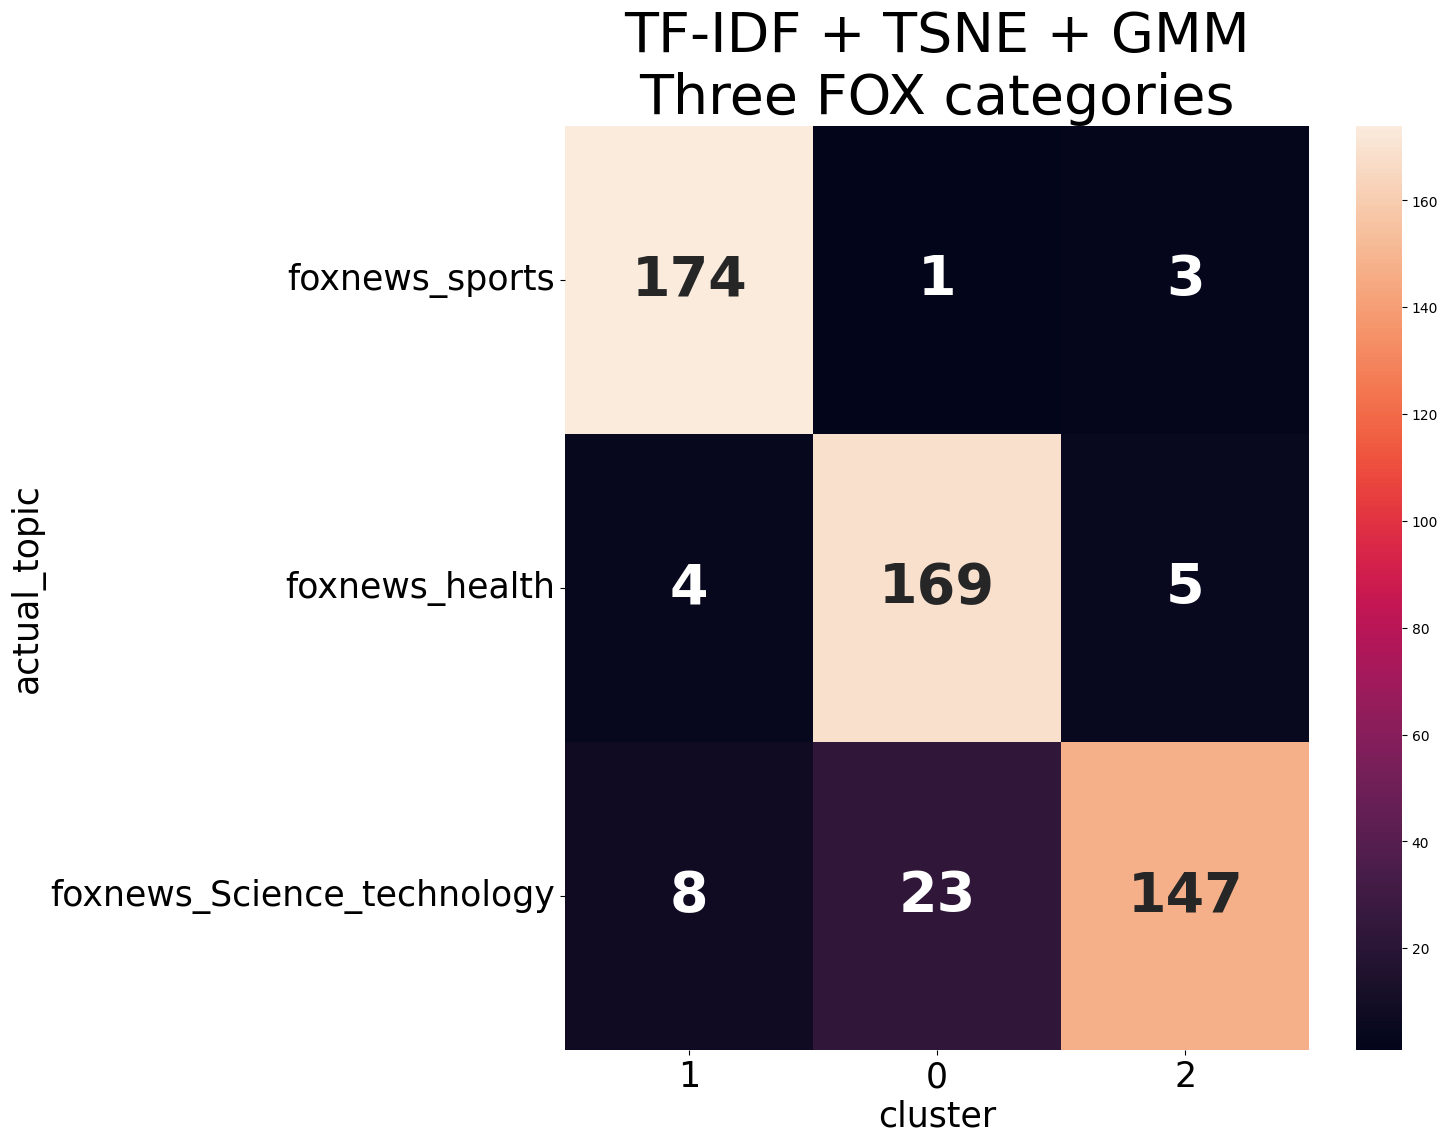

In [68]:
plot_and_save_confusion_matrix(res_table, top_title='TF-IDF + TSNE + GMM', bottom_title='Three FOX categories')

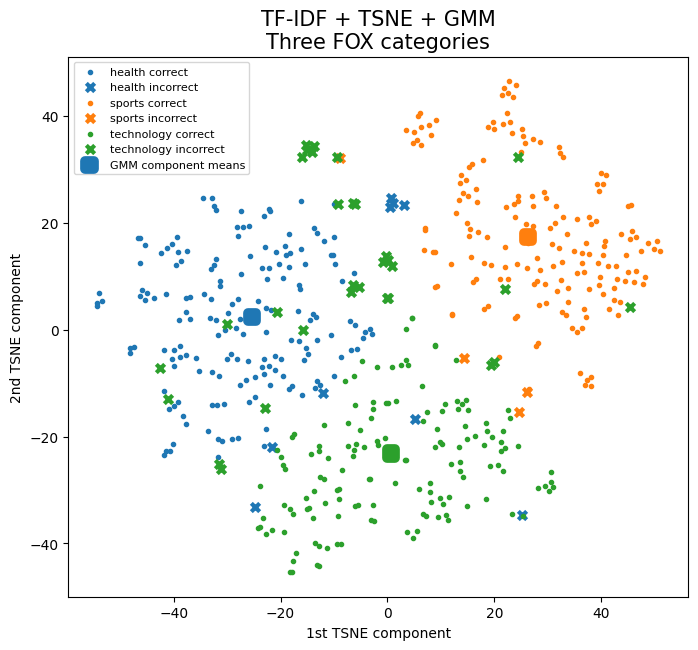

In [69]:
plot_and_save_clustering_results(gm_results, gm.means_, n_groups=3, 
                                 kmeans_or_gmm=False, cnn_or_fox=False, 
                                 top_title='TF-IDF + TSNE + GMM', bottom_title='Three FOX categories')

### 2-class split

In this subsection, data from `foxnews_health` and `foxnews_sports` is used. For this data, using NMF on TF-IDF data (see below) achieved accuracy of 0.983, which is the best result comparing to other two-topic splits of FOX news data. NMF on TF data achieved a lower accuracy of 0.935.

Here, TSNE+Clustering achieved better results than NMF, GMM clustring achieved slightly better results than K-means.

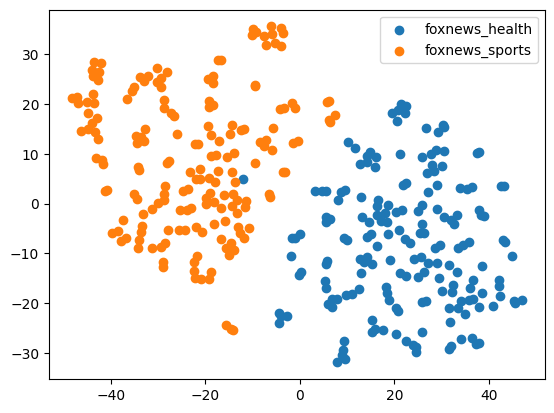

In [70]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('tsne', TSNE(n_components=2, init='random', random_state=rs, metric='cosine', method='exact', 
                            perplexity=30, n_jobs=-1))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_sports']].tolist())
X_embedded=pipe.fit_transform(dataloc)

fig, ax = plt.subplots()
ax.scatter(*X_embedded[:178].T,label=dataloc.index[0].split('.')[0])
ax.scatter(*X_embedded[178:].T,label=dataloc.index[-1].split('.')[0])
ax.legend();

In [71]:
km = KMeans(n_clusters=2, random_state=rs, n_init='auto')
km_results=km.fit_predict(X_embedded)
res_table=results_table(dataloc.index, km_results, nmf_or_clustering=False)
res_table

cluster           0    1
actual_topic            
foxnews_health  177    1
foxnews_sports    3  175

In [72]:
evaluate(km_results, n_classes=2, cnn_or_fox=False)

0.9887640449438202

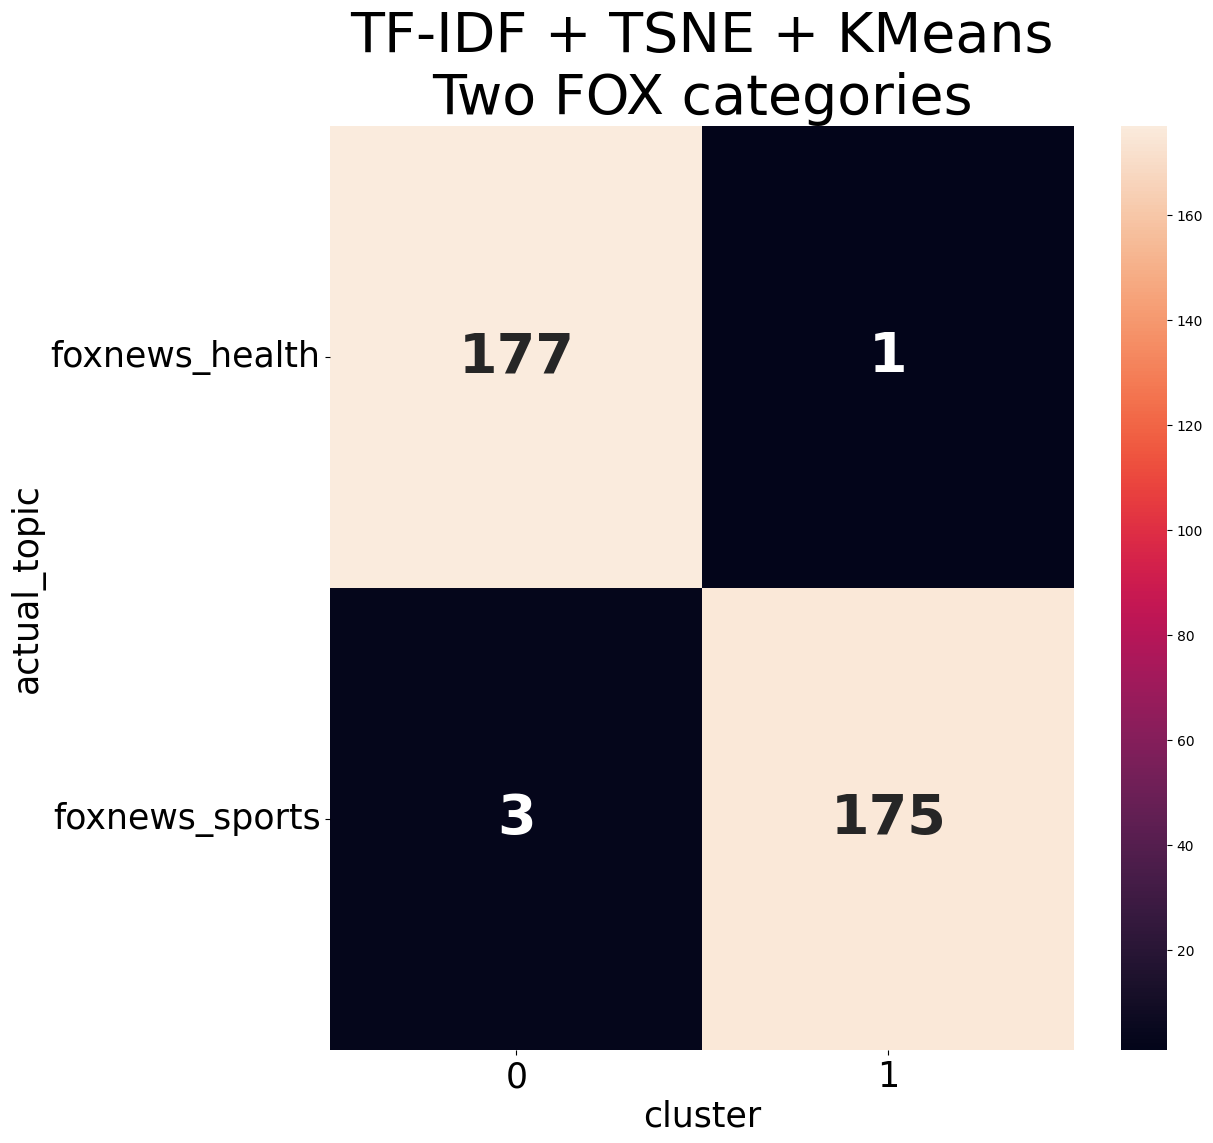

In [73]:
plot_and_save_confusion_matrix(res_table, top_title='TF-IDF + TSNE + KMeans', bottom_title='Two FOX categories')

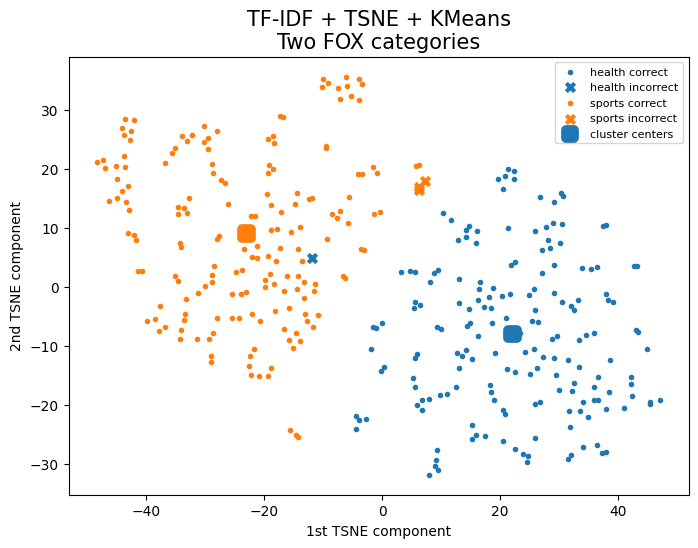

In [74]:
plot_and_save_clustering_results(km_results, km.cluster_centers_, n_groups=2, 
                                 kmeans_or_gmm=True, cnn_or_fox=False, 
                                 top_title='TF-IDF + TSNE + KMeans', bottom_title='Two FOX categories')

In [75]:
gm = GaussianMixture(n_components=2, init_params='kmeans', random_state=rs, 
                     covariance_type='spherical')
gm_results=gm.fit_predict(X_embedded)
res_table=results_table(dataloc.index, gm_results, nmf_or_clustering=False)
res_table

cluster           1    0
actual_topic            
foxnews_sports  178    0
foxnews_health    1  177

In [76]:
evaluate(gm_results, n_classes=2, cnn_or_fox=False)

0.9971910112359551

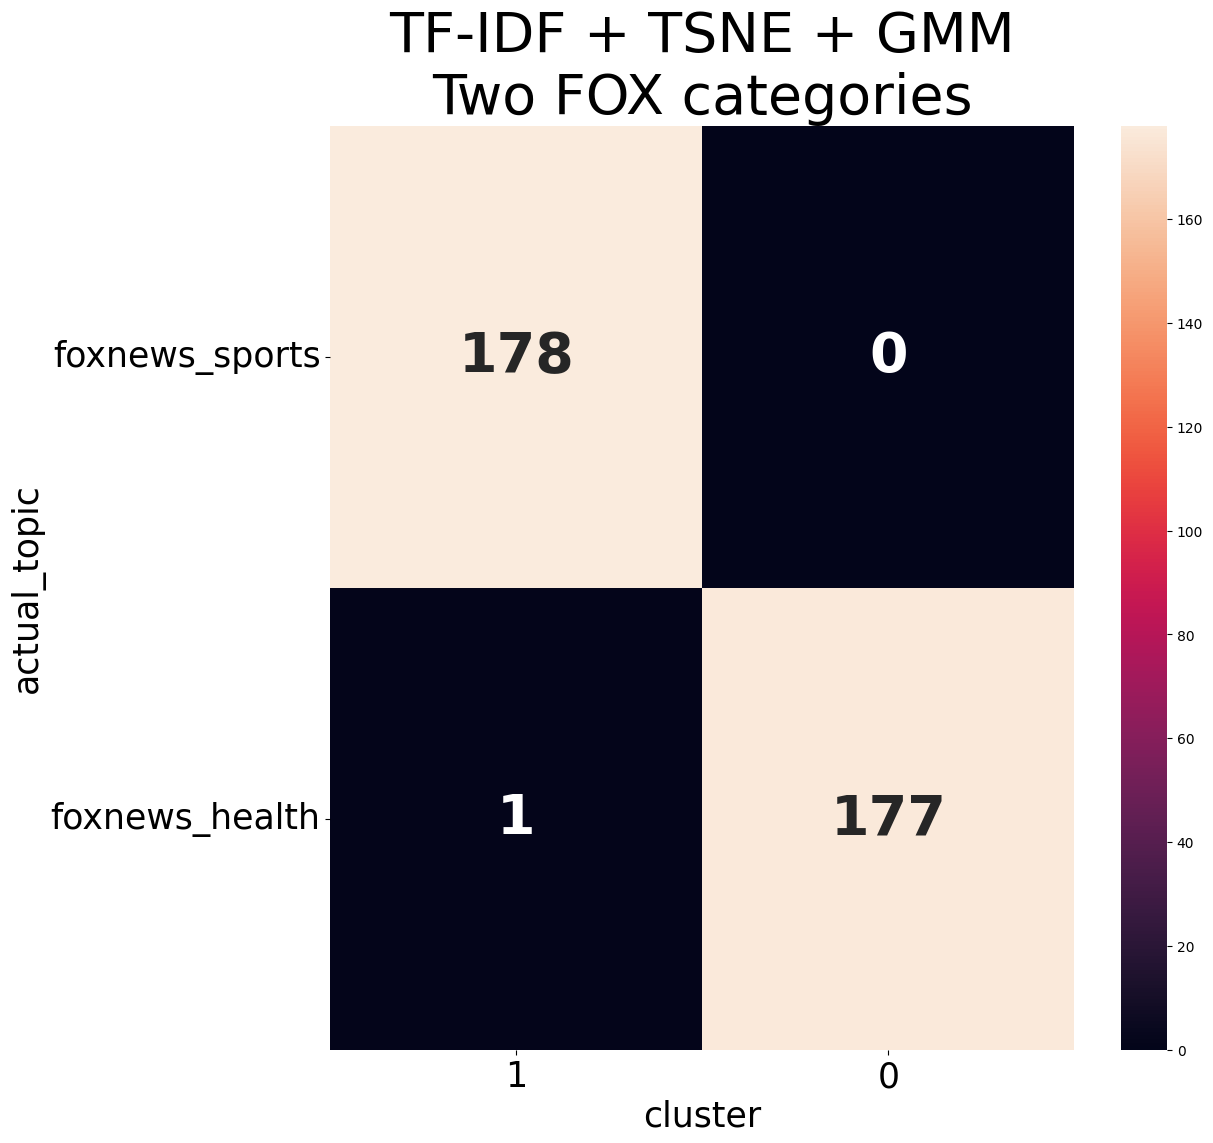

In [77]:
plot_and_save_confusion_matrix(res_table, top_title='TF-IDF + TSNE + GMM', bottom_title='Two FOX categories')

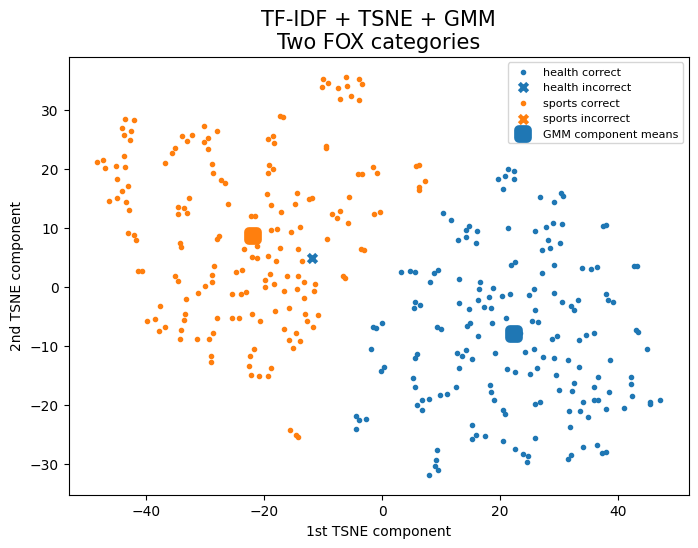

In [78]:
plot_and_save_clustering_results(gm_results, gm.means_, n_groups=2, 
                                 kmeans_or_gmm=False, cnn_or_fox=False, 
                                 top_title='TF-IDF + TSNE + GMM', bottom_title='Two FOX categories')

# NMF

In this section, `Non-negative matrix factorization (NMF)` is used for topic extraction from the text data. Then, the most prevalent topic is calculated for each document, and the distributions of most prevalent topic labels are compared with original class distributions via confusion matrices.

## TF-IDF + NMF

In this section, `term frequency - inverse document frequency (TF-IDF)` is used to encode text data. 

Here, in every subsection transforming and embedding the data is done via a similar pipeline.
```python
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
```
First, `TfidfVectorizer` is used to compute the TF-IDF for 1000 most common words, but only among those who are present in >1% and <95% of documents. Then, `NMF` transforms the data down to `n_components` dimensions using random initialization with a fixed random state. The only hyperparameter changed from one subsection to another is `n_components`, which is equal to the number of classes in the data sample.

### fox 2-class search

In this subsection, the pipeline is fit to all 2-class combinations of FOX News data. Then, evry result is evaluated on how well it matches up with the original class labels.

In [79]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])

search_among_sections_df(pipe=pipe, n_classes=2, cnn_or_fox=False)

['foxnews_health', 'foxnews_Science_technology']
['foxnews_health', 'foxnews_sports']
['foxnews_health', 'foxnews_travel']
['foxnews_Science_technology', 'foxnews_sports']
['foxnews_Science_technology', 'foxnews_travel']
['foxnews_sports', 'foxnews_travel']


0         1
1              (foxnews_health, foxnews_sports)  0.983146
0  (foxnews_health, foxnews_Science_technology)  0.966292
2              (foxnews_health, foxnews_travel)  0.963483
3  (foxnews_Science_technology, foxnews_sports)  0.960674
5              (foxnews_sports, foxnews_travel)  0.957865
4  (foxnews_Science_technology, foxnews_travel)  0.949438

So, for all 2-class combinations of FOX News data NMF on TF-IDF does a good job of extracting topics that align well with the original labels.

Selecting the best-performing 2-class combination and analysing it separately.

In [80]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_sports']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=False)

0.9831460674157303

Creating the confusion matrix.

In [81]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    1    0
actual_topic                
foxnews_health      178    0
foxnews_sports        6  172

The results match up with the original class labels pretty well, there are few "misclassifications".

Plotting and saving the confusion matrix.

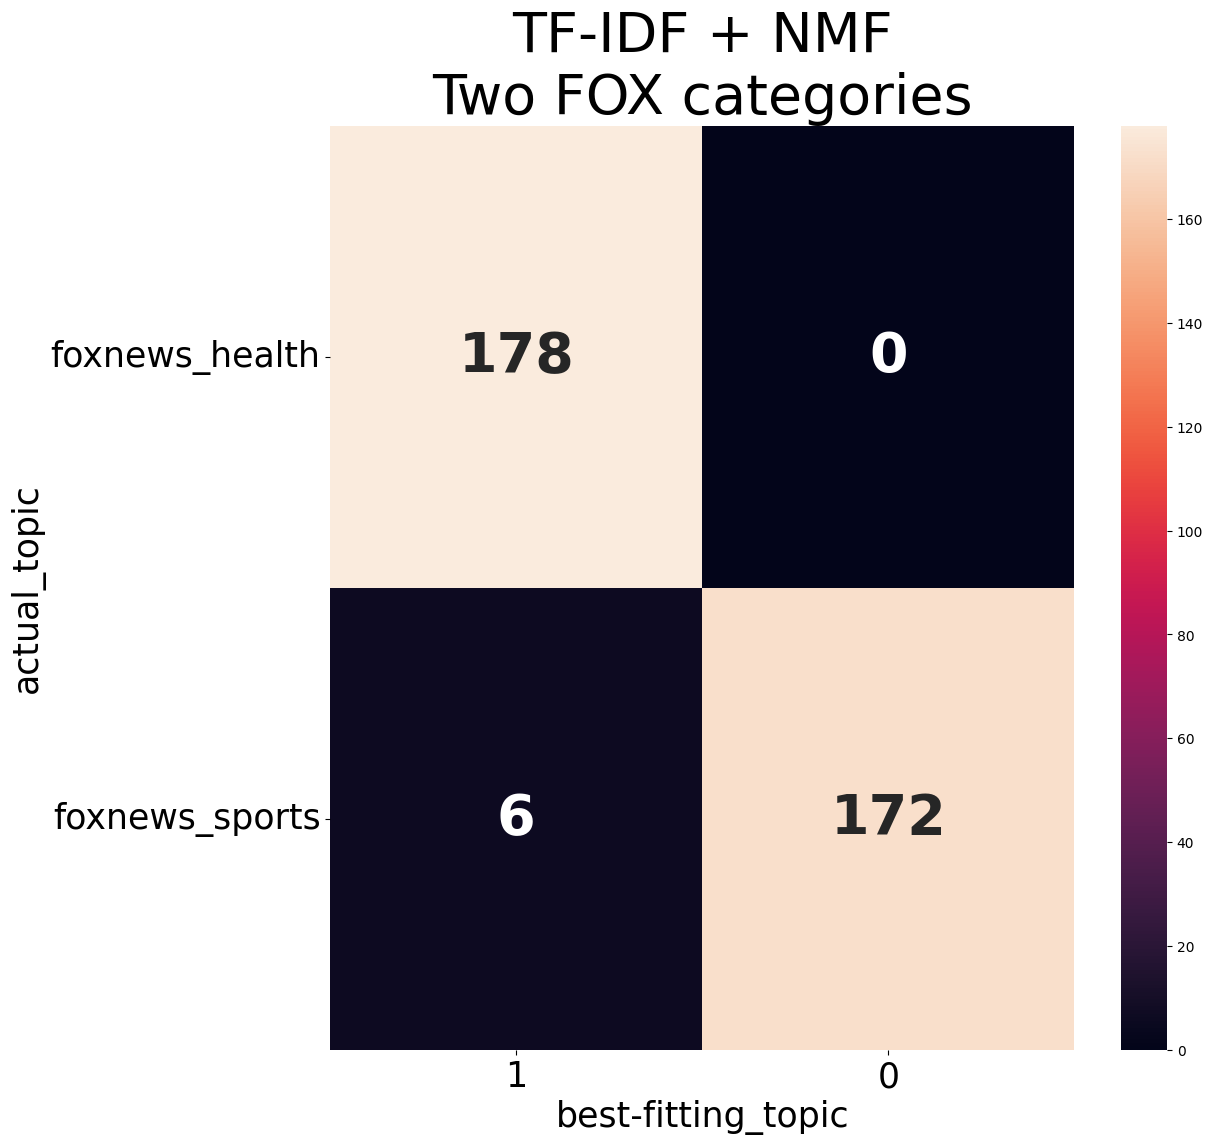

In [82]:
plot_and_save_confusion_matrix(res_table, top_title='TF-IDF + NMF', bottom_title='Two FOX categories')

### fox 3-class search

In this subsection, the pipeline is fit to all 3-class combinations of FOX News data. Then, every result is evaluated on how well it matches up with the original class labels.

In [83]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=3, init='random', random_state=rs,max_iter=1000))])

search_among_sections_df(pipe=pipe, n_classes=3, cnn_or_fox=False)

['foxnews_health', 'foxnews_Science_technology', 'foxnews_sports']
['foxnews_health', 'foxnews_Science_technology', 'foxnews_travel']
['foxnews_health', 'foxnews_sports', 'foxnews_travel']
['foxnews_Science_technology', 'foxnews_sports', 'foxnews_travel']


0         1
0  (foxnews_health, foxnews_Science_technology, f...  0.958801
3  (foxnews_Science_technology, foxnews_sports, f...  0.934457
1  (foxnews_health, foxnews_Science_technology, f...  0.915730
2   (foxnews_health, foxnews_sports, foxnews_travel)  0.558052

So, for 3 of the 4 3-class combinations of FOX News data NMF on TF-IDF does a good job of extracting topics that align well with the original labels. However, for one particular combination the model does poorly.

Analysing the bad-performing case separately.

In [84]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=3, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_sports', 'foxnews_travel']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=3, cnn_or_fox=False)

0.5580524344569289

Creating the confusion matrix.

In [85]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    0    1   2
actual_topic                    
foxnews_health        0  177   1
foxnews_travel        0  172   6
foxnews_sports      115   16  47

So, in this particular setup the model didn't differentiate well between `foxnews_health` and `foxnews_travel`, which is strange, since these classes were well separated into different topics in the other 3-class combination where they were present, as well as in the 2-class combination.

Trying the same model with a different `random_state`.

In [86]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=3, init='random', random_state=12345,max_iter=1000))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_sports', 'foxnews_travel']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=3, cnn_or_fox=False)

0.9644194756554307

In [87]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    1    0    2
actual_topic                     
foxnews_travel      176    2    0
foxnews_sports        6  171    1
foxnews_health       10    0  168

This time, the results are much better! 

Trying the same thing with the original value of `random_state`, but with a different order of rows in the dataset.

In [88]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=3, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['foxnews_sports', 'foxnews_health', 'foxnews_travel']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=3, cnn_or_fox=False)

0.9662921348314607

In [89]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    0    2    1
actual_topic                     
foxnews_travel      175    2    1
foxnews_sports        6  171    1
foxnews_health        8    0  170

Also a good result. 

Plotting and saving the confusion matrix.

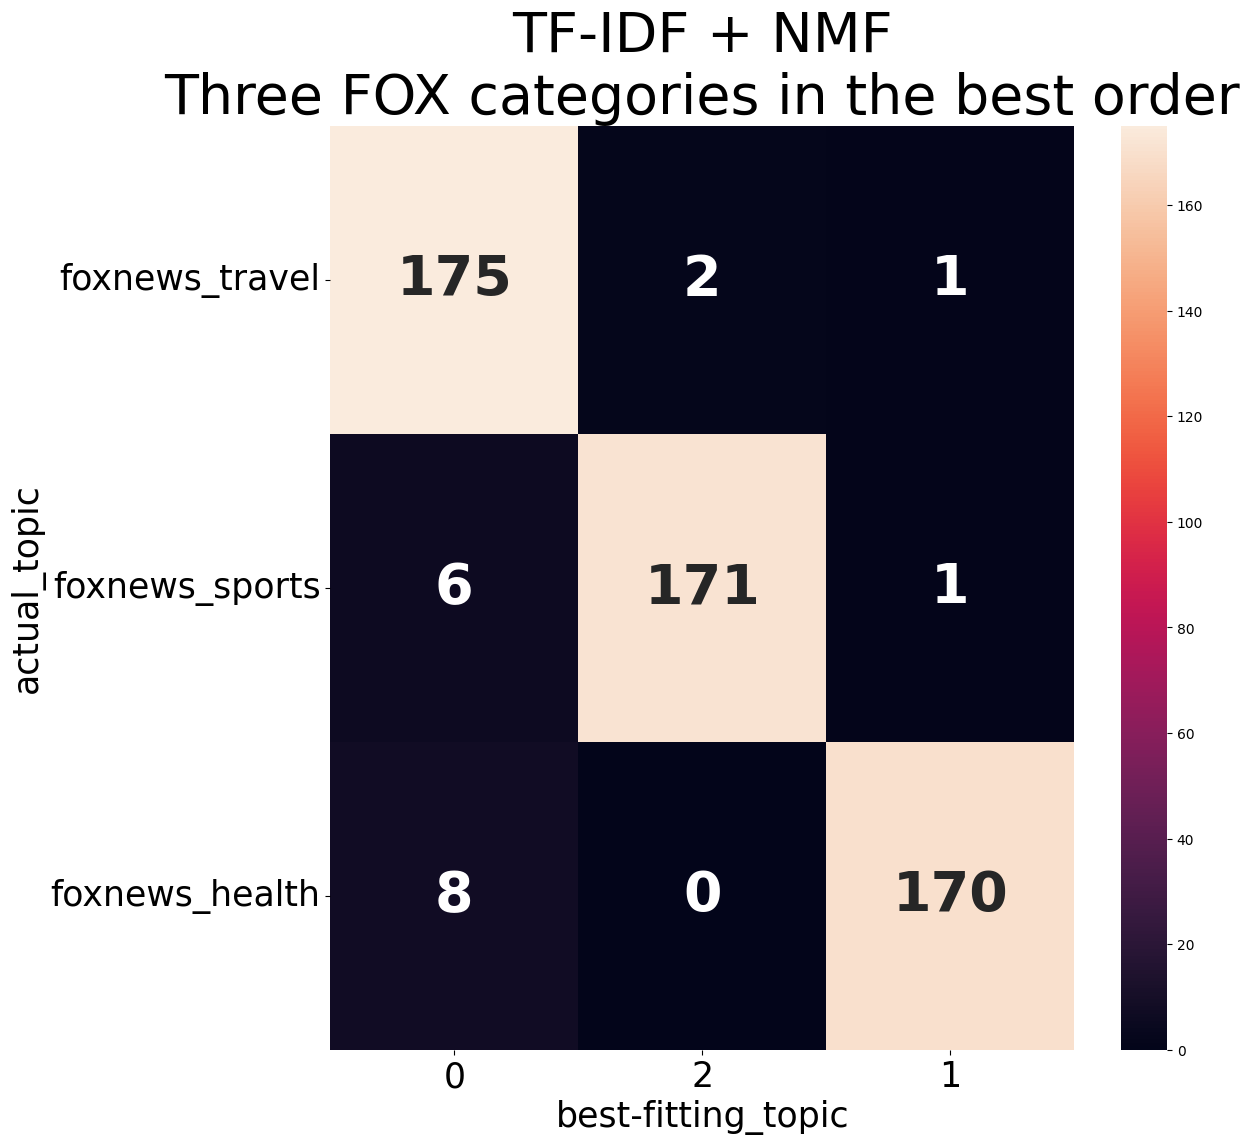

In [90]:
plot_and_save_confusion_matrix(res_table, top_title='TF-IDF + NMF', bottom_title='Three FOX categories in the best order')

### fox all 4

In this subsection, the pipeline is fit to all FOX News data. Then, the result is evaluated on how well it matches up with the original class labels.

The resulting topics match up with the original classes well even in the 4-class setting.

In [91]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=4, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[fox_folders].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=4, cnn_or_fox=False)

0.8230337078651685

In [92]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic            0    2    3   1
actual_topic                                 
foxnews_travel              175    2    1   0
foxnews_sports                5  172    1   0
foxnews_health               14    0  163   1
foxnews_Science_technology   31    1   70  76

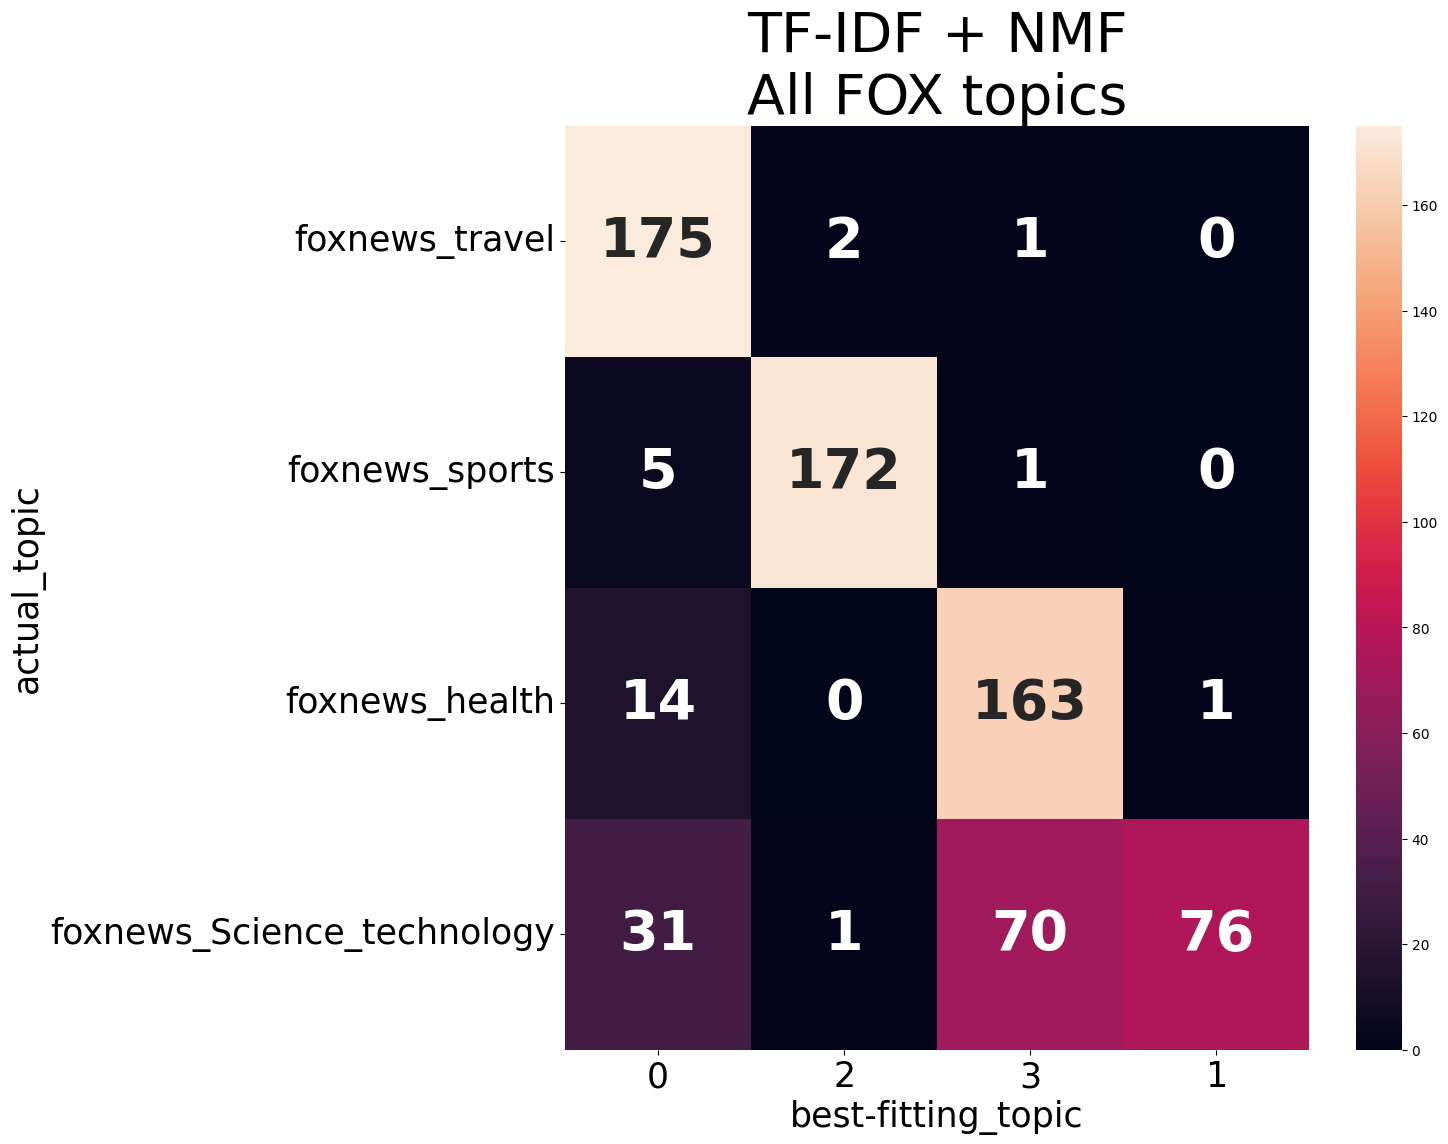

In [93]:
plot_and_save_confusion_matrix(res_table, top_title='TF-IDF + NMF', bottom_title='All FOX topics')

### cnn 2-class search

In this subsection, the pipeline is fit to all 2-class combinations of CNN data. Then, every result is evaluated on how well it matches up with the original class labels.

In [94]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])

search_among_sections_df(pipe=pipe, n_classes=2, cnn_or_fox=True)

['cnn_crime', 'cnn_politics']
['cnn_crime', 'cnn_living']
['cnn_crime', 'cnn_health']
['cnn_crime', 'cnn_technology']
['cnn_crime', 'cnn_travel']
['cnn_crime', 'cnn_entertainment']
['cnn_politics', 'cnn_living']
['cnn_politics', 'cnn_health']
['cnn_politics', 'cnn_technology']
['cnn_politics', 'cnn_travel']
['cnn_politics', 'cnn_entertainment']
['cnn_living', 'cnn_health']
['cnn_living', 'cnn_technology']
['cnn_living', 'cnn_travel']
['cnn_living', 'cnn_entertainment']
['cnn_health', 'cnn_technology']
['cnn_health', 'cnn_travel']
['cnn_health', 'cnn_entertainment']
['cnn_technology', 'cnn_travel']
['cnn_technology', 'cnn_entertainment']
['cnn_travel', 'cnn_entertainment']


0         1
3           (cnn_crime, cnn_technology)  0.989865
4               (cnn_crime, cnn_travel)  0.972973
1               (cnn_crime, cnn_living)  0.972973
15         (cnn_health, cnn_technology)  0.952703
2               (cnn_crime, cnn_health)  0.942568
12         (cnn_living, cnn_technology)  0.891892
5        (cnn_crime, cnn_entertainment)  0.871622
11             (cnn_living, cnn_health)  0.844595
18         (cnn_technology, cnn_travel)  0.750000
13             (cnn_living, cnn_travel)  0.743243
19  (cnn_technology, cnn_entertainment)  0.733108
16             (cnn_health, cnn_travel)  0.716216
0             (cnn_crime, cnn_politics)  0.641892
7            (cnn_politics, cnn_health)  0.621622
8        (cnn_politics, cnn_technology)  0.621622
9            (cnn_politics, cnn_travel)  0.621622
10    (cnn_politics, cnn_entertainment)  0.618243
6            (cnn_politics, cnn_living)  0.618243
17      (cnn_health, cnn_entertainment)  0.570946
14      (cnn_living, cnn_entertainment)  0.567568
20      (cnn_travel, cnn_entertainment)  0.567568

So, for CNN data some 2-class splits with NMF are matching up with original labels well, while others aren't.

Selecting one of the splits and analysing it separately.

In [95]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['cnn_crime', 'cnn_politics']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=True)

0.6418918918918919

In [96]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    1   0
actual_topic               
cnn_crime           147   1
cnn_politics        105  43

One of the resulting topics clearly corresponds to a part of the `cnn_politics` data, but overall the split is not great. 

Trying the same thing with a different `random_state`.

In [97]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=2, init='random', random_state=123456,max_iter=1000))])
dataloc=pd.concat(data.loc[['cnn_crime', 'cnn_politics']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=True)

0.6891891891891891

In [98]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    0   1
actual_topic               
cnn_crime           147   1
cnn_politics         91  57

Only a slight improvement.

Trying the same thing with a different oeder of rows.

In [99]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['cnn_politics','cnn_crime']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=True)

0.6891891891891893

In [100]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    0   1
actual_topic               
cnn_crime           147   1
cnn_politics         91  57

Looks like NMF is unable to produce a good split of this particular TF-IDF data.

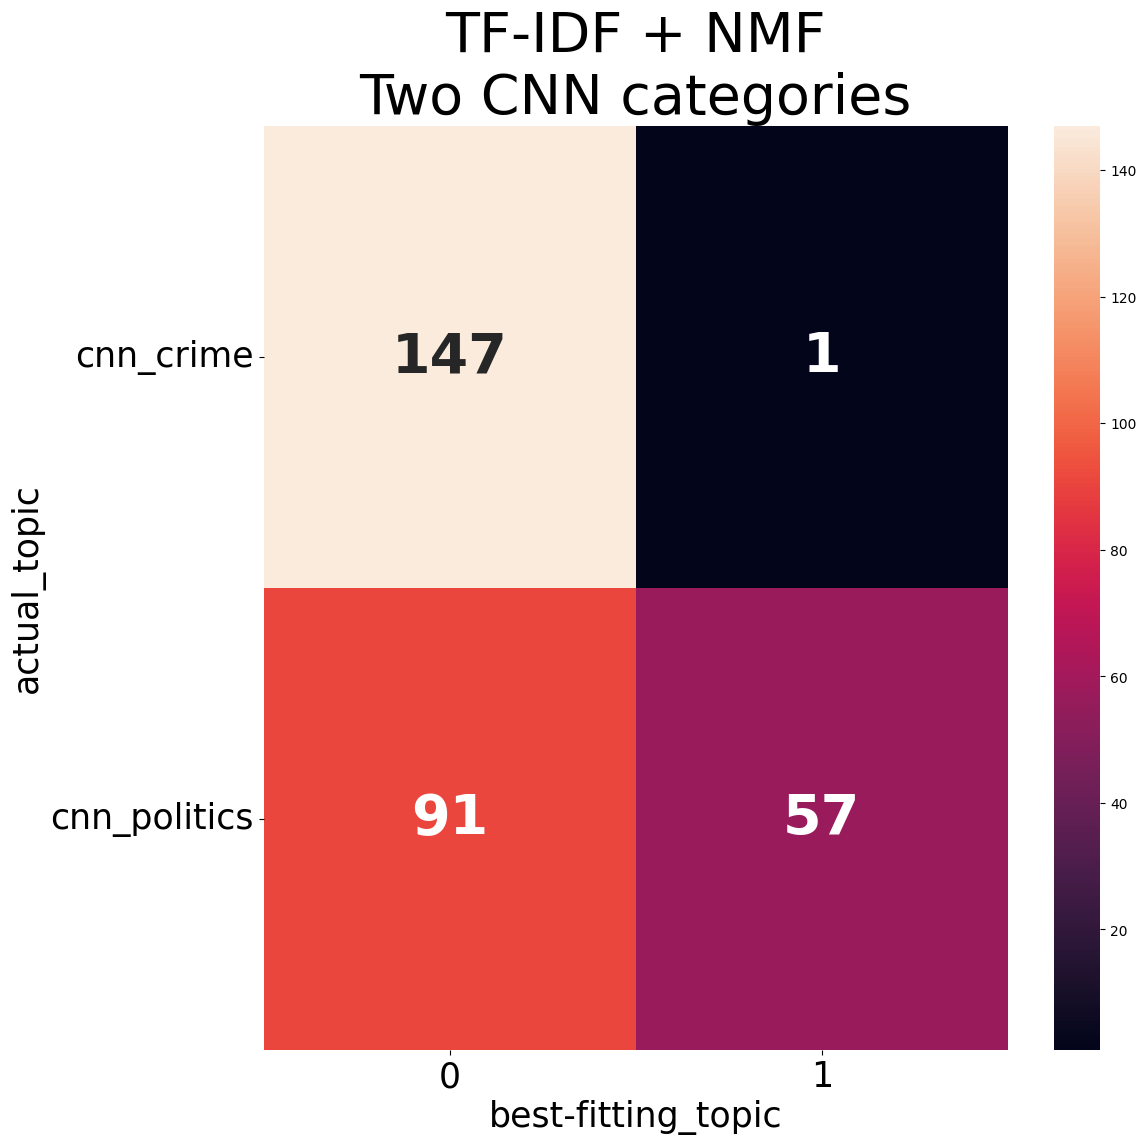

In [101]:
plot_and_save_confusion_matrix(res_table, top_title='TF-IDF + NMF', bottom_title='Two CNN categories')

### cnn 3-class search

In this subsection, the pipeline is fit to all 3-class combinations of CNN data. Then, every result is evaluated on how well it matches up with the original class labels.

In [102]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=3, init='random', random_state=rs,max_iter=1000))])

search_among_sections_df(pipe=pipe, n_classes=3, cnn_or_fox=True)

['cnn_crime', 'cnn_politics', 'cnn_living']
['cnn_crime', 'cnn_politics', 'cnn_health']
['cnn_crime', 'cnn_politics', 'cnn_technology']
['cnn_crime', 'cnn_politics', 'cnn_travel']
['cnn_crime', 'cnn_politics', 'cnn_entertainment']
['cnn_crime', 'cnn_living', 'cnn_health']
['cnn_crime', 'cnn_living', 'cnn_technology']
['cnn_crime', 'cnn_living', 'cnn_travel']
['cnn_crime', 'cnn_living', 'cnn_entertainment']
['cnn_crime', 'cnn_health', 'cnn_technology']
['cnn_crime', 'cnn_health', 'cnn_travel']
['cnn_crime', 'cnn_health', 'cnn_entertainment']
['cnn_crime', 'cnn_technology', 'cnn_travel']
['cnn_crime', 'cnn_technology', 'cnn_entertainment']
['cnn_crime', 'cnn_travel', 'cnn_entertainment']
['cnn_politics', 'cnn_living', 'cnn_health']
['cnn_politics', 'cnn_living', 'cnn_technology']
['cnn_politics', 'cnn_living', 'cnn_travel']
['cnn_politics', 'cnn_living', 'cnn_entertainment']
['cnn_politics', 'cnn_health', 'cnn_technology']
['cnn_politics', 'cnn_health', 'cnn_travel']
['cnn_politics', 'cn

0         1
6             (cnn_crime, cnn_living, cnn_technology)  0.887387
12            (cnn_crime, cnn_technology, cnn_travel)  0.815315
25           (cnn_living, cnn_health, cnn_technology)  0.810811
32    (cnn_health, cnn_technology, cnn_entertainment)  0.808559
11         (cnn_crime, cnn_health, cnn_entertainment)  0.806306
7                 (cnn_crime, cnn_living, cnn_travel)  0.797297
10                (cnn_crime, cnn_health, cnn_travel)  0.759009
8          (cnn_crime, cnn_living, cnn_entertainment)  0.756757
14         (cnn_crime, cnn_travel, cnn_entertainment)  0.754505
2           (cnn_crime, cnn_politics, cnn_technology)  0.727477
0               (cnn_crime, cnn_politics, cnn_living)  0.713964
3               (cnn_crime, cnn_politics, cnn_travel)  0.713964
1               (cnn_crime, cnn_politics, cnn_health)  0.691441
13     (cnn_crime, cnn_technology, cnn_entertainment)  0.684685
9             (cnn_crime, cnn_health, cnn_technology)  0.677928
5                 (cnn_crime, cnn_living, cnn_health)  0.666667
20             (cnn_politics, cnn_health, cnn_travel)  0.648649
4        (cnn_crime, cnn_politics, cnn_entertainment)  0.648649
23  (cnn_politics, cnn_technology, cnn_entertainment)  0.601351
22         (cnn_politics, cnn_technology, cnn_travel)  0.601351
17             (cnn_politics, cnn_living, cnn_travel)  0.599099
30        (cnn_living, cnn_travel, cnn_entertainment)  0.587838
26               (cnn_living, cnn_health, cnn_travel)  0.565315
18      (cnn_politics, cnn_living, cnn_entertainment)  0.560811
16         (cnn_politics, cnn_living, cnn_technology)  0.556306
15             (cnn_politics, cnn_living, cnn_health)  0.547297
19         (cnn_politics, cnn_health, cnn_technology)  0.540541
21      (cnn_politics, cnn_health, cnn_entertainment)  0.536036
24      (cnn_politics, cnn_travel, cnn_entertainment)  0.524775
27        (cnn_living, cnn_health, cnn_entertainment)  0.522523
28           (cnn_living, cnn_technology, cnn_travel)  0.520270
31           (cnn_health, cnn_technology, cnn_travel)  0.509009
34    (cnn_technology, cnn_travel, cnn_entertainment)  0.506757
33        (cnn_health, cnn_travel, cnn_entertainment)  0.502252
29    (cnn_living, cnn_technology, cnn_entertainment)  0.490991

### cnn 4-class search

In this subsection, the pipeline is fit to all 4-class combinations of CNN data. Then, every result is evaluated on how well it matches up with the original class labels.

In [103]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=4, init='random', random_state=rs,max_iter=1000))])

search_among_sections_df(pipe=pipe, n_classes=4, cnn_or_fox=True)

['cnn_crime', 'cnn_politics', 'cnn_living', 'cnn_health']
['cnn_crime', 'cnn_politics', 'cnn_living', 'cnn_technology']
['cnn_crime', 'cnn_politics', 'cnn_living', 'cnn_travel']
['cnn_crime', 'cnn_politics', 'cnn_living', 'cnn_entertainment']
['cnn_crime', 'cnn_politics', 'cnn_health', 'cnn_technology']
['cnn_crime', 'cnn_politics', 'cnn_health', 'cnn_travel']
['cnn_crime', 'cnn_politics', 'cnn_health', 'cnn_entertainment']
['cnn_crime', 'cnn_politics', 'cnn_technology', 'cnn_travel']
['cnn_crime', 'cnn_politics', 'cnn_technology', 'cnn_entertainment']
['cnn_crime', 'cnn_politics', 'cnn_travel', 'cnn_entertainment']
['cnn_crime', 'cnn_living', 'cnn_health', 'cnn_technology']
['cnn_crime', 'cnn_living', 'cnn_health', 'cnn_travel']
['cnn_crime', 'cnn_living', 'cnn_health', 'cnn_entertainment']
['cnn_crime', 'cnn_living', 'cnn_technology', 'cnn_travel']
['cnn_crime', 'cnn_living', 'cnn_technology', 'cnn_entertainment']
['cnn_crime', 'cnn_living', 'cnn_travel', 'cnn_entertainment']
['cnn_c

0         1
16  (cnn_crime, cnn_health, cnn_technology, cnn_tr...  0.805743
13  (cnn_crime, cnn_living, cnn_technology, cnn_tr...  0.766892
4   (cnn_crime, cnn_politics, cnn_health, cnn_tech...  0.758446
34  (cnn_health, cnn_technology, cnn_travel, cnn_e...  0.726351
7   (cnn_crime, cnn_politics, cnn_technology, cnn_...  0.695946
10  (cnn_crime, cnn_living, cnn_health, cnn_techno...  0.687500
2   (cnn_crime, cnn_politics, cnn_living, cnn_travel)  0.670608
8   (cnn_crime, cnn_politics, cnn_technology, cnn_...  0.670608
1   (cnn_crime, cnn_politics, cnn_living, cnn_tech...  0.643581
3   (cnn_crime, cnn_politics, cnn_living, cnn_ente...  0.633446
11    (cnn_crime, cnn_living, cnn_health, cnn_travel)  0.631757
32  (cnn_living, cnn_health, cnn_travel, cnn_enter...  0.628378
23  (cnn_politics, cnn_living, cnn_technology, cnn...  0.628378
19  (cnn_crime, cnn_technology, cnn_travel, cnn_en...  0.628378
15  (cnn_crime, cnn_living, cnn_travel, cnn_entert...  0.626689
0   (cnn_crime, cnn_politics, cnn_living, cnn_health)  0.626689
17  (cnn_crime, cnn_health, cnn_technology, cnn_en...  0.621622
30  (cnn_living, cnn_health, cnn_technology, cnn_t...  0.621622
14  (cnn_crime, cnn_living, cnn_technology, cnn_en...  0.614865
12  (cnn_crime, cnn_living, cnn_health, cnn_entert...  0.608108
18  (cnn_crime, cnn_health, cnn_travel, cnn_entert...  0.608108
20  (cnn_politics, cnn_living, cnn_health, cnn_tec...  0.604730
31  (cnn_living, cnn_health, cnn_technology, cnn_e...  0.601351
5   (cnn_crime, cnn_politics, cnn_health, cnn_travel)  0.572635
9   (cnn_crime, cnn_politics, cnn_travel, cnn_ente...  0.570946
28  (cnn_politics, cnn_health, cnn_travel, cnn_ent...  0.565878
21  (cnn_politics, cnn_living, cnn_health, cnn_tra...  0.559122
6   (cnn_crime, cnn_politics, cnn_health, cnn_ente...  0.550676
25  (cnn_politics, cnn_living, cnn_travel, cnn_ent...  0.548986
22  (cnn_politics, cnn_living, cnn_health, cnn_ent...  0.543919
29  (cnn_politics, cnn_technology, cnn_travel, cnn...  0.538851
26  (cnn_politics, cnn_health, cnn_technology, cnn...  0.537162
24  (cnn_politics, cnn_living, cnn_technology, cnn...  0.520270
33  (cnn_living, cnn_technology, cnn_travel, cnn_e...  0.494932
27  (cnn_politics, cnn_health, cnn_technology, cnn...  0.489865

## TF + NMF

In this section, simple word counts (a.k.a `Term Frequency`) are used to encode text data. 

Here, in every subsection transforming and embedding the data is done via a similar pipeline.
```python
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
```
First, `CountVectorizer` is used to count occurances of the 1000 most common words.  Then, `NMF` transforms the data down to `n_components` dimensions using random initialization with a fixed random state. The only hyperparameter changed from one subsection to another is `n_components`, which is equal to the number of classes in the data sample.

### fox 2-class search and a bad result

In this subsection, the pipeline is fit to all 2-class combinations of FOX News data. Then, evry result is evaluated on how well it matches up with the original class labels.

In [104]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])

search_among_sections_df(pipe=pipe, n_classes=2, cnn_or_fox=False)

['foxnews_health', 'foxnews_Science_technology']
['foxnews_health', 'foxnews_sports']
['foxnews_health', 'foxnews_travel']
['foxnews_Science_technology', 'foxnews_sports']
['foxnews_Science_technology', 'foxnews_travel']
['foxnews_sports', 'foxnews_travel']


0         1
5              (foxnews_sports, foxnews_travel)  0.966292
1              (foxnews_health, foxnews_sports)  0.935393
3  (foxnews_Science_technology, foxnews_sports)  0.932584
2              (foxnews_health, foxnews_travel)  0.882022
4  (foxnews_Science_technology, foxnews_travel)  0.839888
0  (foxnews_health, foxnews_Science_technology)  0.519663

For 5 out of 6 2-class combinations of FOX News data NMF on TF achieves a slightly worse, but still decent result. However, for the combinaion of `foxnews_health` and `foxnews_Science_technology` the result is poor.

Analysing the poor result separately and trying other row order and `random_state` value.

In [105]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['foxnews_Science_technology', 'foxnews_health']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=False)

0.5196629213483146

In [106]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('nmf', NMF(n_components=2, init='random', random_state=123,max_iter=1000))])
dataloc=pd.concat(data.loc[['foxnews_Science_technology', 'foxnews_health']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=False)

0.5224719101123596

In [107]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_Science_technology']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=False)

0.5196629213483146

No real improvement.

In [108]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic            0  1
actual_topic                      
foxnews_health              177  1
foxnews_Science_technology  170  8

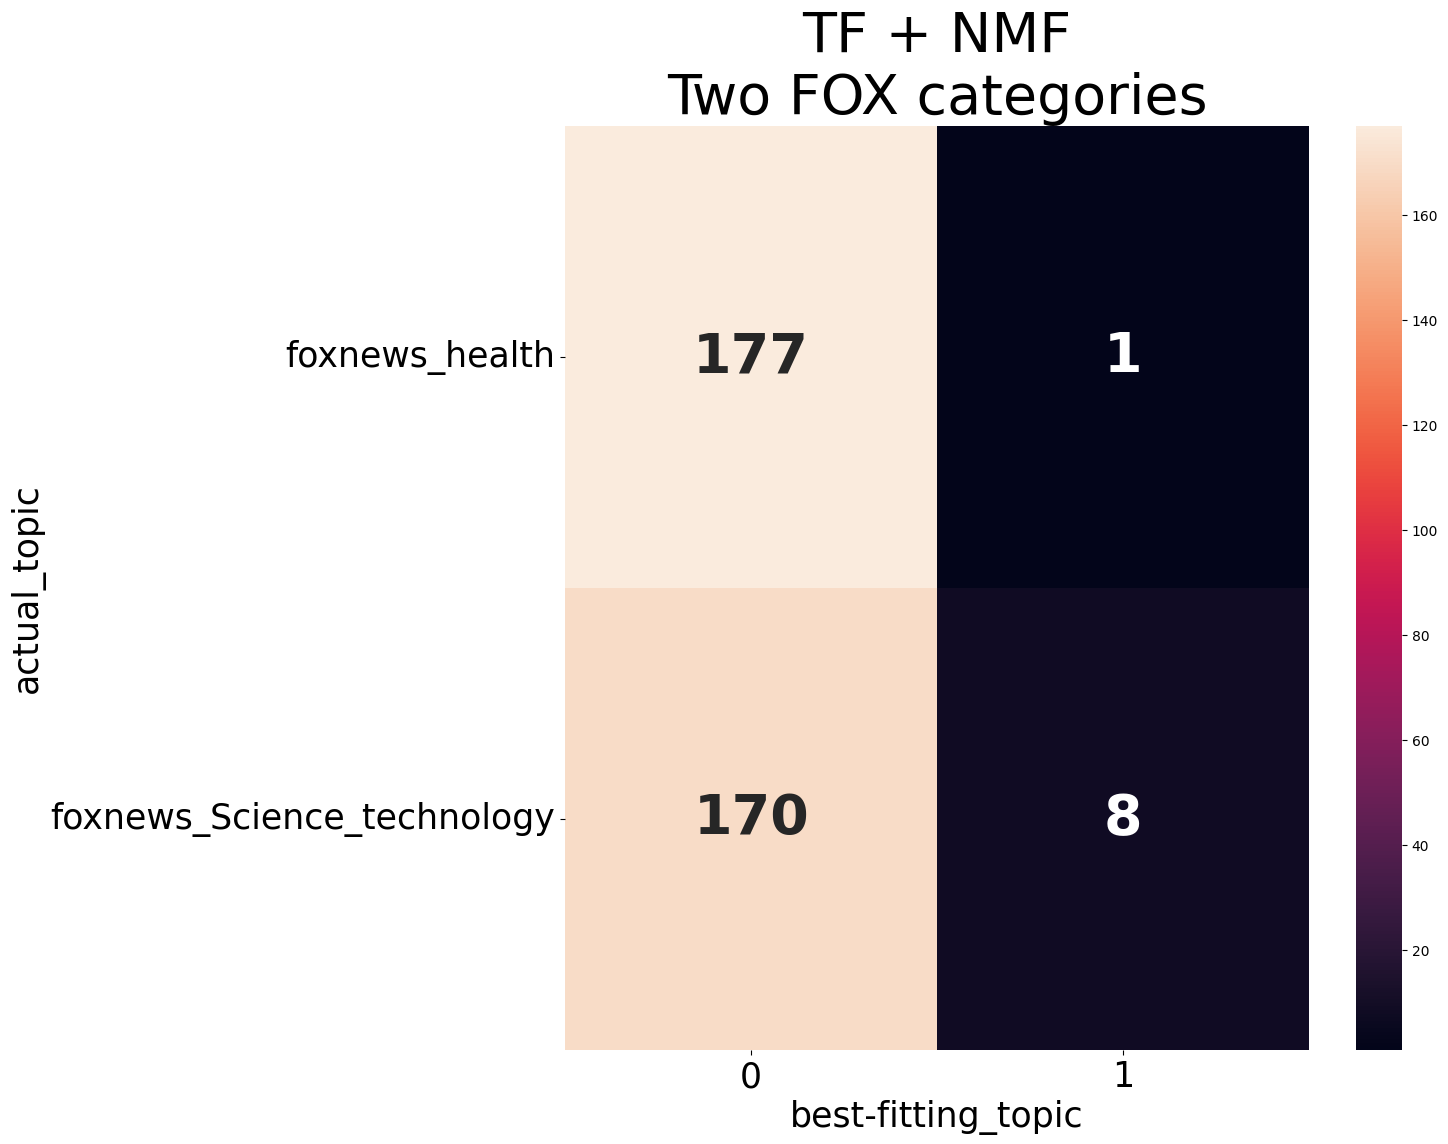

In [109]:
plot_and_save_confusion_matrix(res_table, top_title='TF + NMF', bottom_title='Two FOX categories')

### good 3-class split fox (data in same order as with the bad TF-IDF + NMF split)

In this subsection, the 3-way split of FOX News data for which NMF on TF-IDF produced a bad result is analysed.

Same order of rows and hyperparameters produce a much better result, but it's still worse than NMF on TF-IDF with a different `random_state` or order of rows. 

In [110]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('nmf', NMF(n_components=3, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_sports', 'foxnews_travel']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=3, cnn_or_fox=False)

0.8895131086142322

In [111]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    1    2    0
actual_topic                     
foxnews_sports      168    6    4
foxnews_health        1  159   18
foxnews_travel        5   25  148

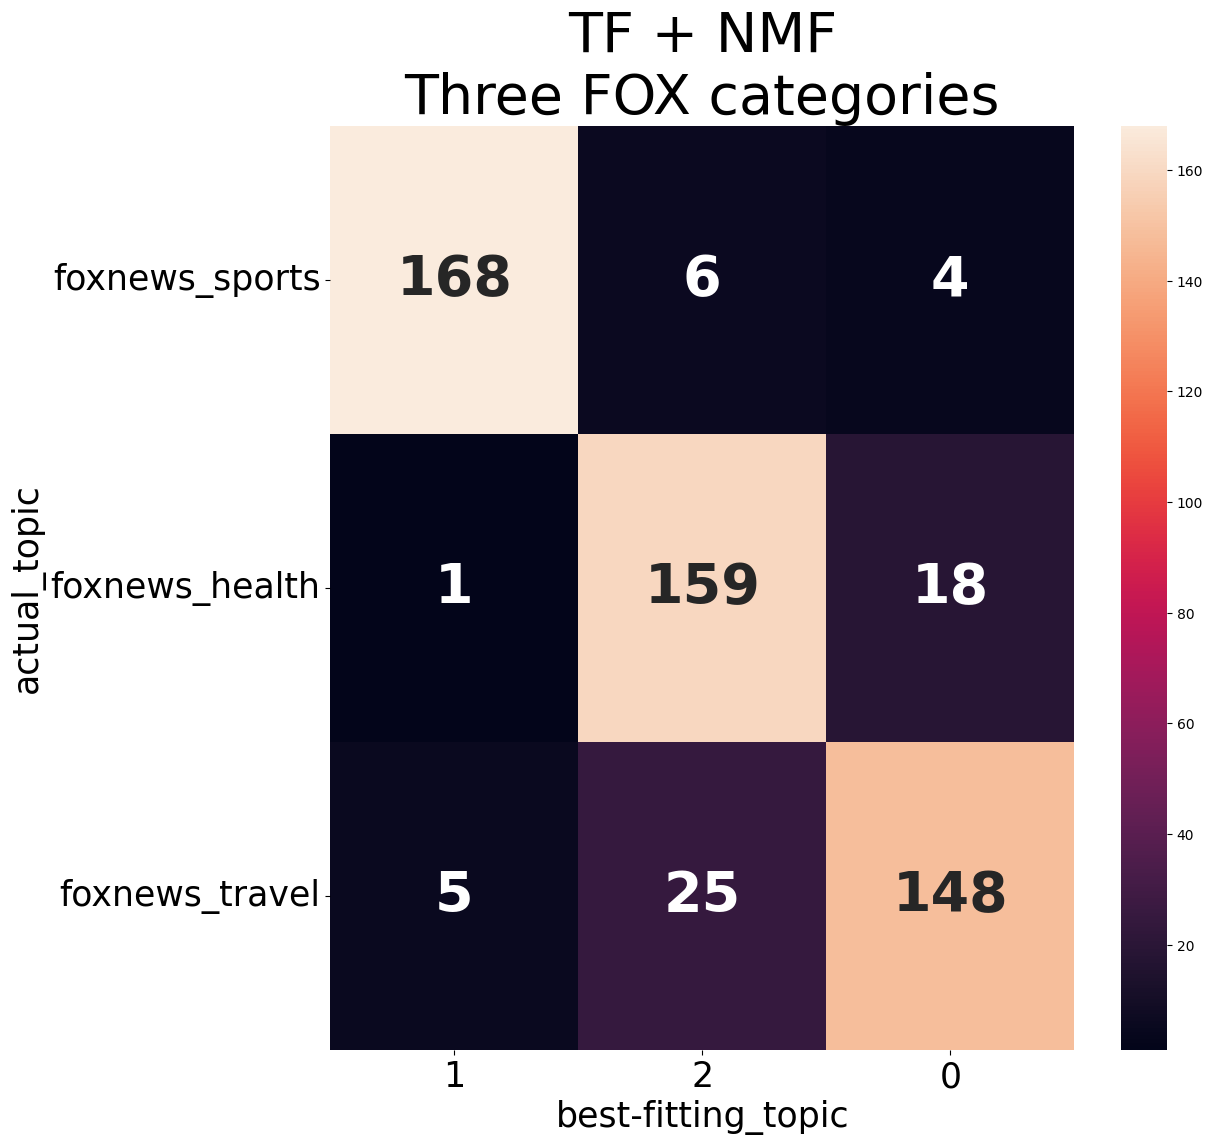

In [112]:
plot_and_save_confusion_matrix(res_table, top_title='TF + NMF', bottom_title='Three FOX categories')

### cnn 2-class search (worse result)

In this subsection, the pipeline is fit to all 2-class combinations of CNN data. Then, every result is evaluated on how well it matches up with the original class labels. Overall, NMF on TF data produces worse results.

The same 2-class combination of CNN data from the TF-IDF + NMF section is analysed. NMF on TF data produces worse results regardless of `random_state` value or order of rows.

In [113]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])

search_among_sections_df(pipe=pipe, n_classes=2, cnn_or_fox=True)

['cnn_crime', 'cnn_politics']
['cnn_crime', 'cnn_living']
['cnn_crime', 'cnn_health']
['cnn_crime', 'cnn_technology']
['cnn_crime', 'cnn_travel']
['cnn_crime', 'cnn_entertainment']
['cnn_politics', 'cnn_living']
['cnn_politics', 'cnn_health']
['cnn_politics', 'cnn_technology']
['cnn_politics', 'cnn_travel']
['cnn_politics', 'cnn_entertainment']
['cnn_living', 'cnn_health']
['cnn_living', 'cnn_technology']
['cnn_living', 'cnn_travel']
['cnn_living', 'cnn_entertainment']
['cnn_health', 'cnn_technology']
['cnn_health', 'cnn_travel']
['cnn_health', 'cnn_entertainment']
['cnn_technology', 'cnn_travel']
['cnn_technology', 'cnn_entertainment']
['cnn_travel', 'cnn_entertainment']


0         1
3           (cnn_crime, cnn_technology)  0.956081
1               (cnn_crime, cnn_living)  0.844595
2               (cnn_crime, cnn_health)  0.841216
5        (cnn_crime, cnn_entertainment)  0.689189
17      (cnn_health, cnn_entertainment)  0.679054
14      (cnn_living, cnn_entertainment)  0.675676
15         (cnn_health, cnn_technology)  0.665541
19  (cnn_technology, cnn_entertainment)  0.621622
12         (cnn_living, cnn_technology)  0.564189
9            (cnn_politics, cnn_travel)  0.533784
11             (cnn_living, cnn_health)  0.530405
4               (cnn_crime, cnn_travel)  0.520270
16             (cnn_health, cnn_travel)  0.516892
13             (cnn_living, cnn_travel)  0.516892
10    (cnn_politics, cnn_entertainment)  0.513514
18         (cnn_technology, cnn_travel)  0.506757
20      (cnn_travel, cnn_entertainment)  0.506757
8        (cnn_politics, cnn_technology)  0.506757
7            (cnn_politics, cnn_health)  0.506757
6            (cnn_politics, cnn_living)  0.506757
0             (cnn_crime, cnn_politics)  0.503378

In [114]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['cnn_crime', 'cnn_politics']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=True)

0.5033783783783784

In [115]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('nmf', NMF(n_components=2, init='random', random_state=123,max_iter=1000))])
dataloc=pd.concat(data.loc[['cnn_crime', 'cnn_politics']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=True)

0.5033783783783784

In [116]:
pipe=Pipeline([('tf',CountVectorizer(strip_accents='ascii',stop_words=words_to_ignore, max_features=1000)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['cnn_politics', 'cnn_crime']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=True)

0.5033783783783784

In [117]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    0  1
actual_topic              
cnn_politics        141  7
cnn_crime           140  8

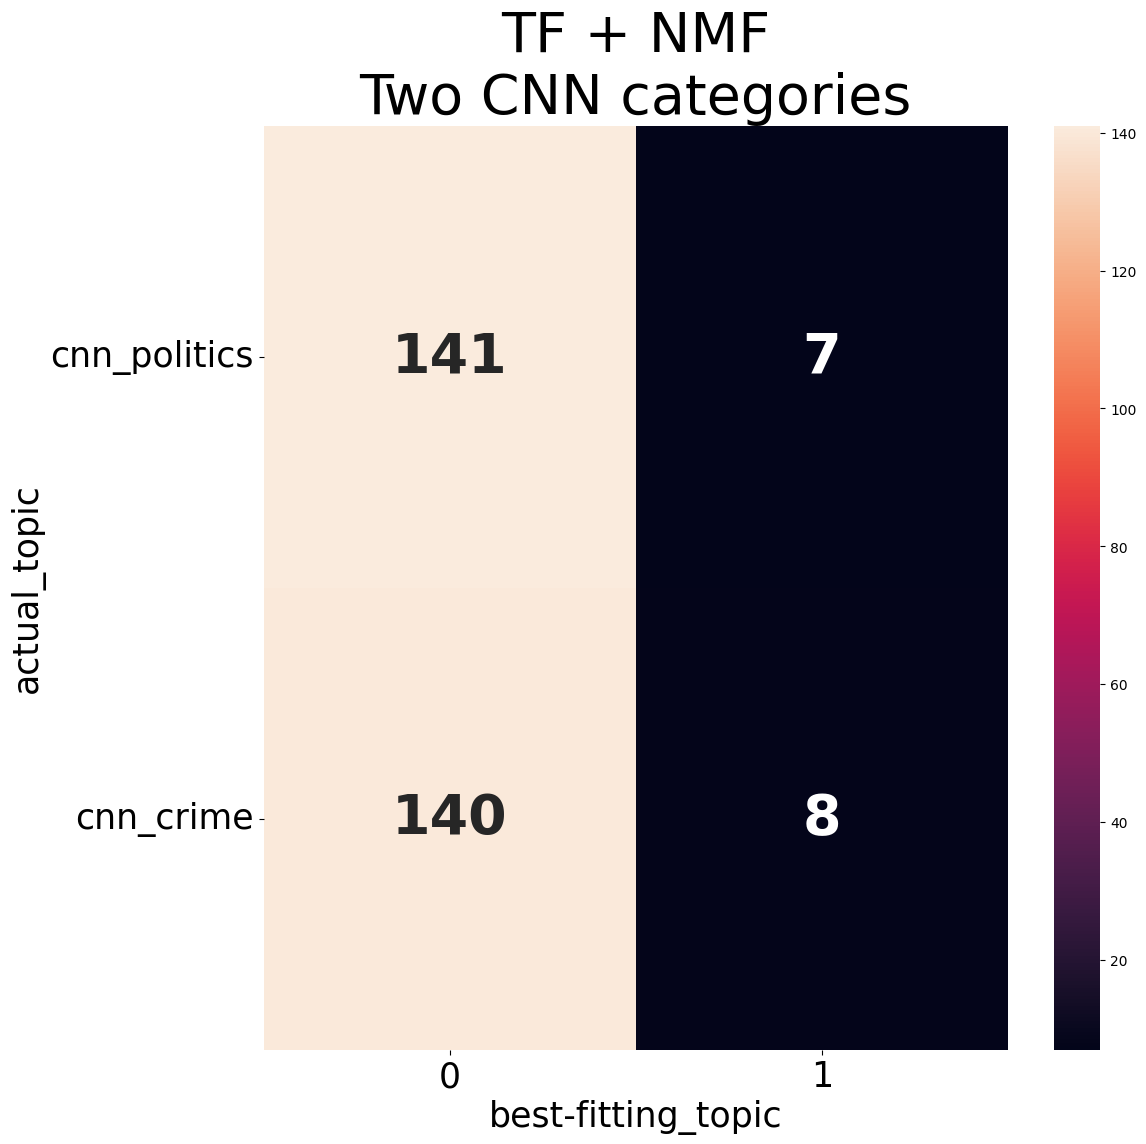

In [118]:
plot_and_save_confusion_matrix(res_table, top_title='TF + NMF', bottom_title='Two CNN categories')

# NMF TOPIC ANALYSIS

In this section, `Non-negative matrix factorization (NMF)` is used for topic extraction from the `TF-IDF` text data. The goal is to create NMF topics best representing the original text topics, and then analyse them by showing the top 10 words most highly associated with each topic.

## FOX

In this subsection, FOX News data is analysed.

To start, using the relatively well-performing model on all 4 classes.

In [119]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=4, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[fox_folders].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=4, cnn_or_fox=False)

0.8230337078651685

In [120]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic            0    2    3   1
actual_topic                                 
foxnews_travel              175    2    1   0
foxnews_sports                5  172    1   0
foxnews_health               14    0  163   1
foxnews_Science_technology   31    1   70  76

Creating and saving a plot showing top 10 words most highly associated with each topic as barplots.

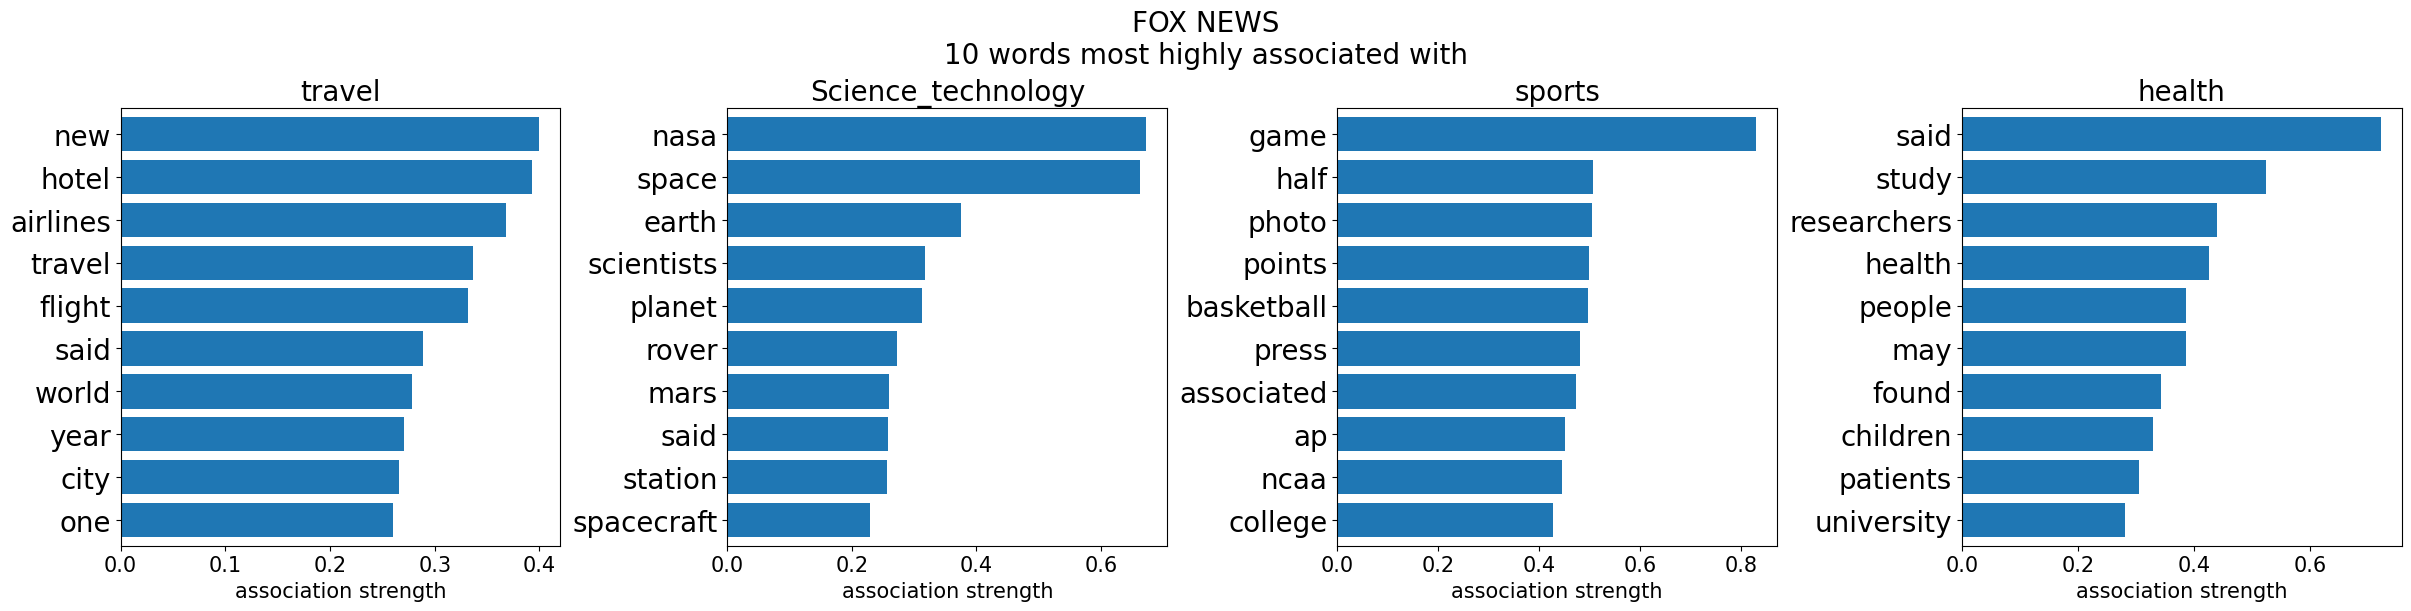

In [121]:
top_ten_words_plot(res_table=res_table, pipe=pipe, upper_title='FOX NEWS')

The words presented on the plot associate well with the 4 topics present in the data.

Doing the same thing for some well-performing NMF models that look at 3 or 2 classes.

In [122]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=3, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['foxnews_health', 'foxnews_Science_technology', 'foxnews_sports']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=3, cnn_or_fox=False)

0.9588014981273408

In [123]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic            0    1    2
actual_topic                             
foxnews_health              177    0    1
foxnews_sports                1  175    2
foxnews_Science_technology   16    2  160

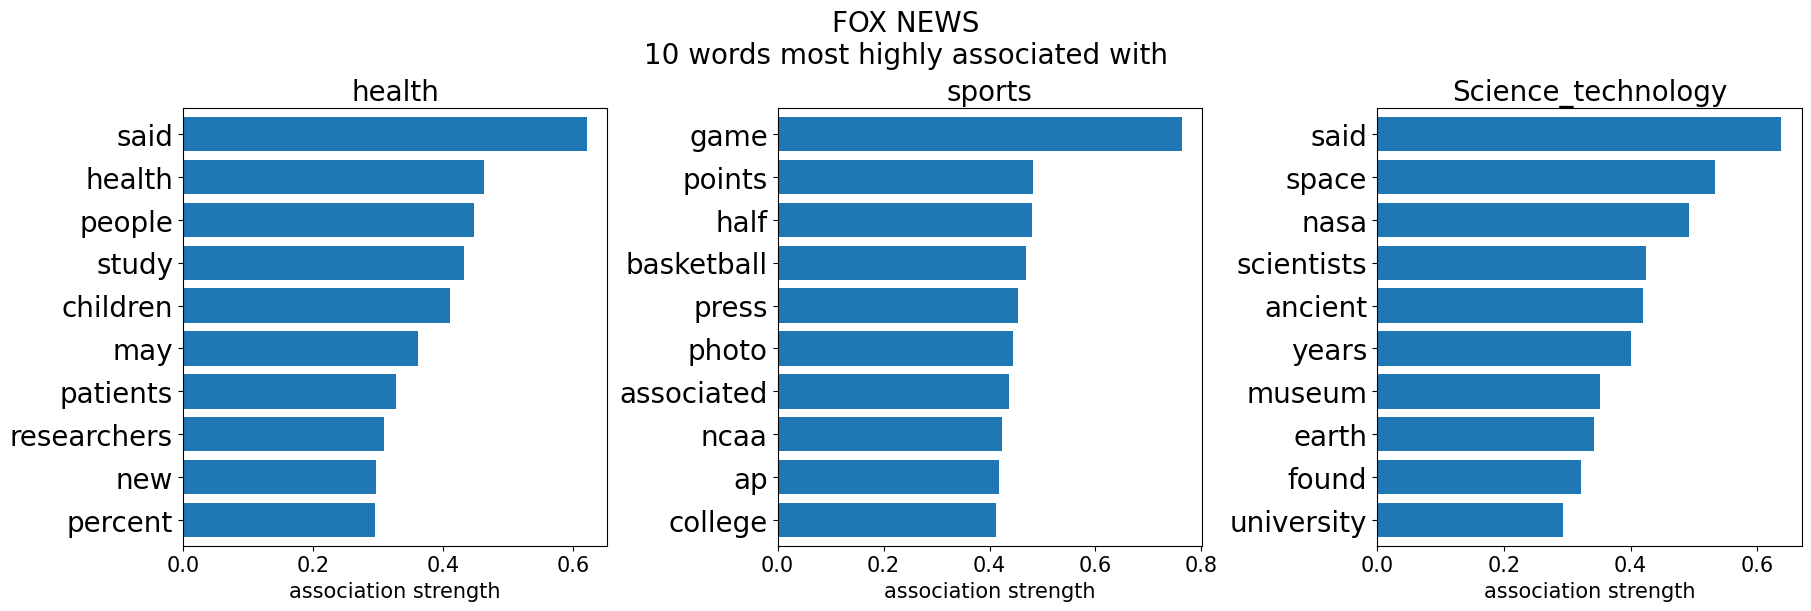

In [124]:
top_ten_words_plot(res_table=res_table, pipe=pipe, upper_title='FOX NEWS')

In [125]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['foxnews_Science_technology', 'foxnews_travel']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=False)

0.949438202247191

In [126]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic            1    0
actual_topic                        
foxnews_Science_technology  170    8
foxnews_travel               10  168

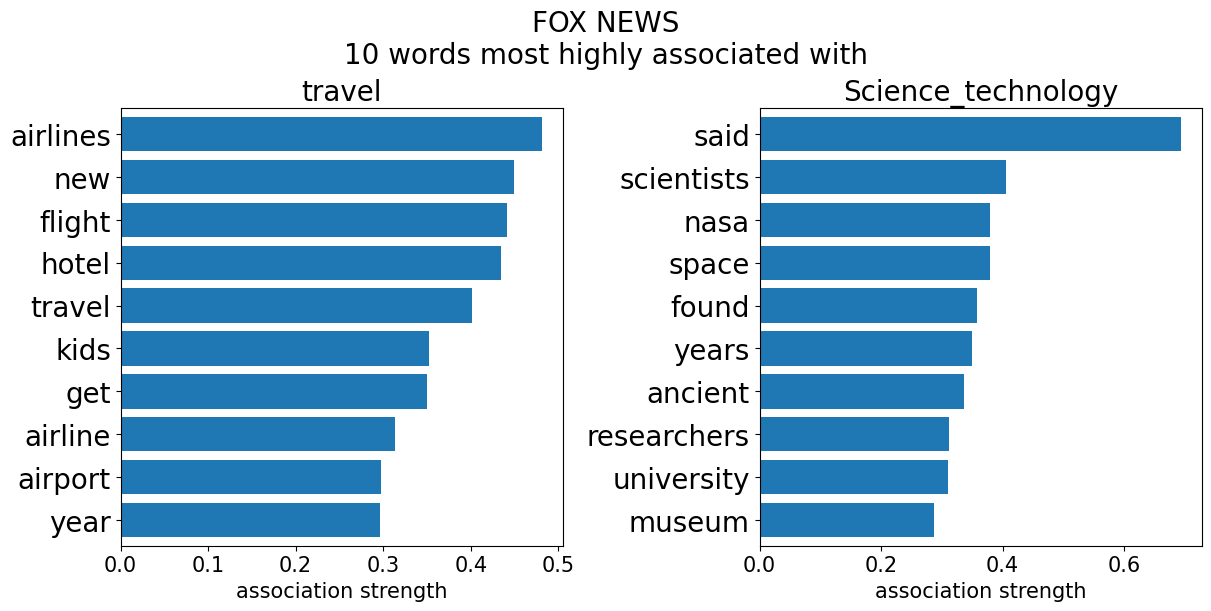

In [127]:
top_ten_words_plot(res_table=res_table, pipe=pipe, upper_title='FOX NEWS')

Overall, each creted NMF topic corresponds well with the presumed topic. Moreover, for any class the lists of top 10 words per topic are quite similar across different models.

The only downside is the presence of the word `said`, which is commonly used in all kinds of news articles to quote someone. It shows up in different topics without adding much information. It should have been added to the list of ignored words during text processing.

## CNN

In this subsection, CNN data is analysed.

The same process is performed with multiple well-performing NMF models for CNN data, trying to cover all 7 topics in the CNN data.

In [128]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=3, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['cnn_health', 'cnn_technology', 'cnn_entertainment']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=3, cnn_or_fox=True)

0.8085585585585585

In [129]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    2    0   1
actual_topic                    
cnn_health          145    3   0
cnn_technology       25  121   2
cnn_entertainment    28   27  93

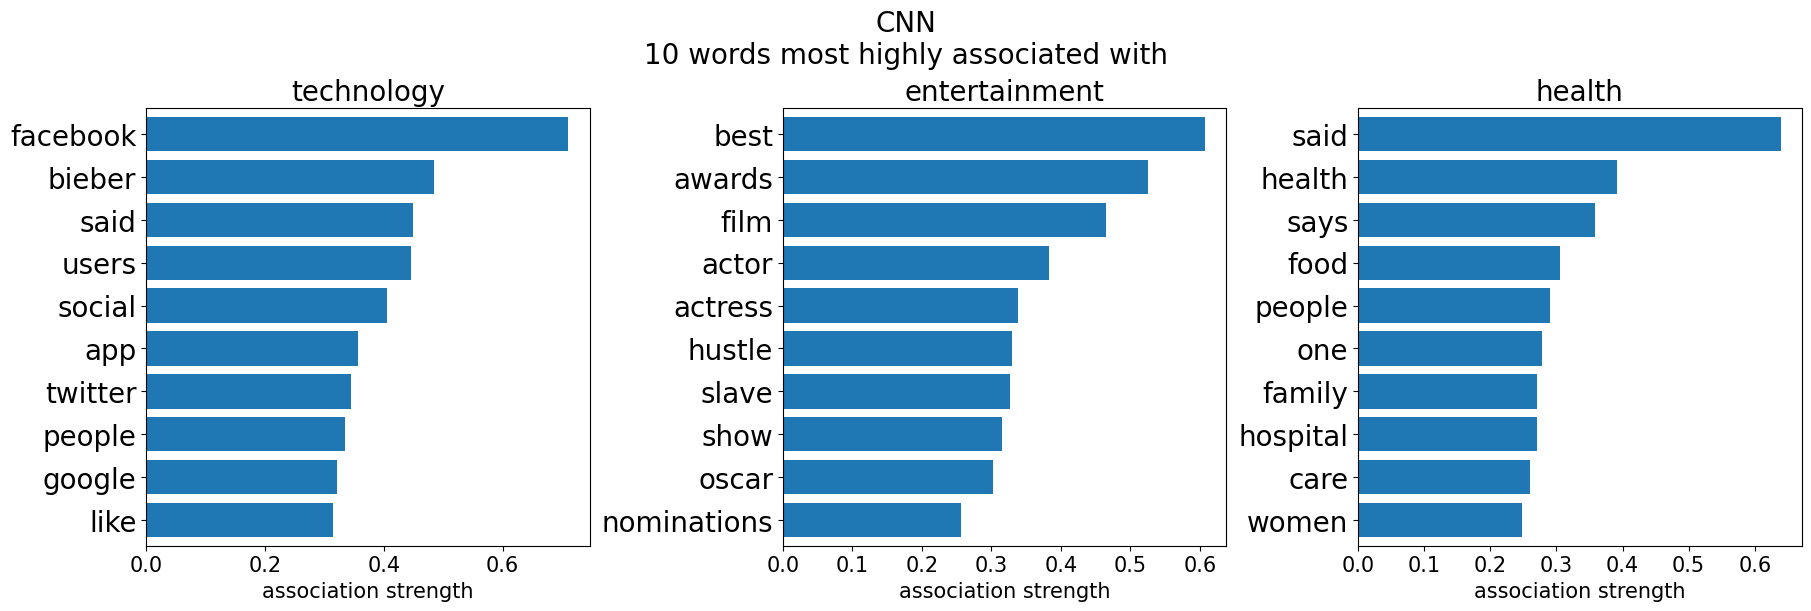

In [130]:
top_ten_words_plot(res_table=res_table, pipe=pipe, upper_title='CNN')

In [131]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=4, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['cnn_crime', 'cnn_living', 'cnn_technology', 'cnn_travel']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=4, cnn_or_fox=True)

0.7668918918918919

In [132]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    3    0    2   1
actual_topic                         
cnn_crime           141    4    1   2
cnn_living            2  137    8   1
cnn_technology        1   38  108   1
cnn_travel            5   73    2  68

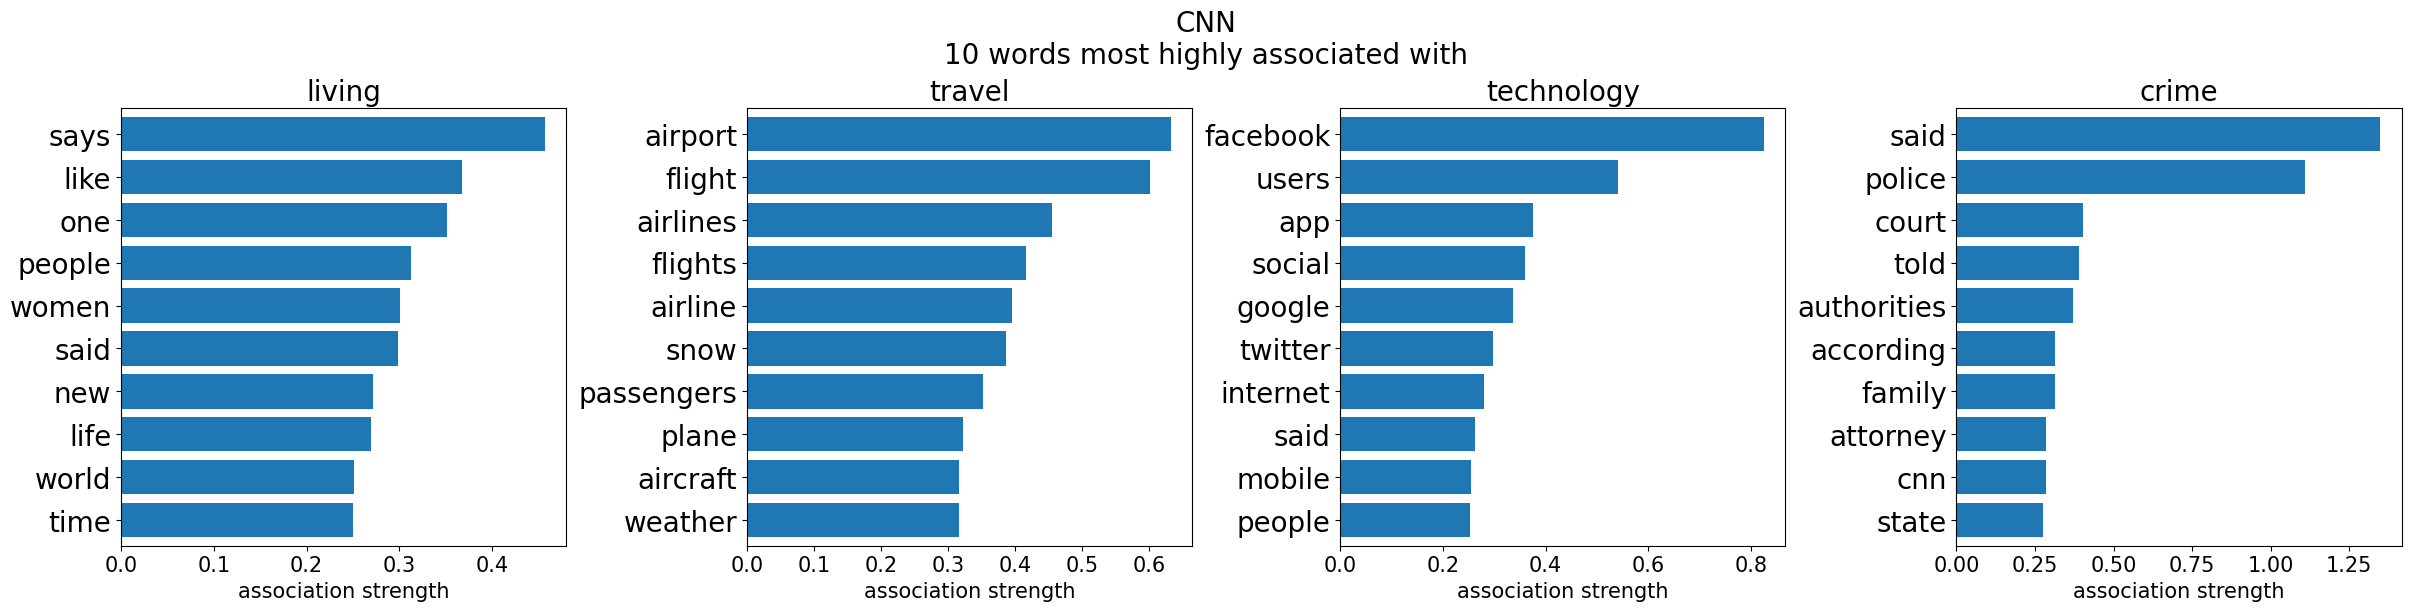

In [133]:
top_ten_words_plot(res_table=res_table, pipe=pipe, upper_title='CNN')

For 6 of the 7 CNN topics (`cnn_crime`, `cnn_living`, `cnn_technology`, `cnn_travel`, `cnn_health` and `cnn_entertainment`), good lists of top 10 words that are seemingly relevant to the topic were found. The problem with the other CNN topic (`cnn_politics`) is that no NMF model was able to create a topic that corresponds well with that data. 

Using the best-performing NMF model with `cnn_politics`.

In [134]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['cnn_crime', 'cnn_politics']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=True)

0.6418918918918919

In [135]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    1   0
actual_topic               
cnn_crime           147   1
cnn_politics        105  43

In this model, one of the topics captures a part of the `cnn_politics` data, while associating everything else with a different topic.

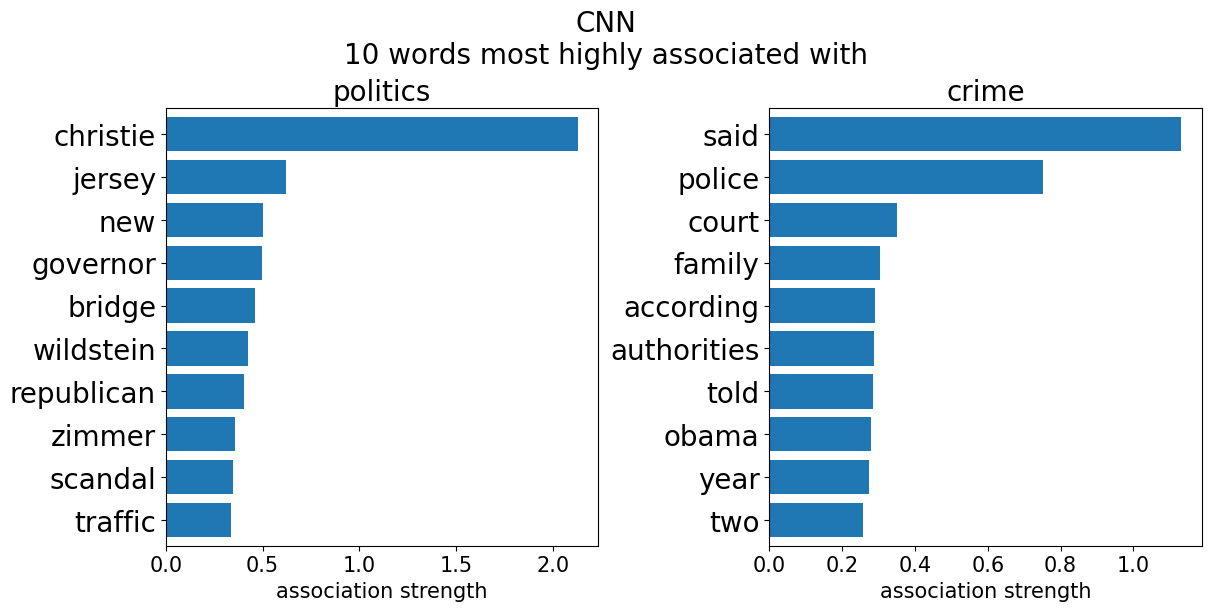

In [136]:
top_ten_words_plot(res_table=res_table, pipe=pipe, upper_title='CNN')

Upon further analysis, the part of the `cnn_politics` used for this project contained many stories about one thing: "Bridgegate", a political scandal in the U.S. state of New Jersey involving Chris Christie (governor of New Jersey at the time). NMF tends to separate stories about "Bridgegate" into it own topic. On the other hand, words that presumably would be important to politics, such as `obama`, ended up in a different topic. This issue should be solvable with better sampling and/or a higher sample size.

Also, the lists of top 10 words for the topics of `cnn_living` and `cnn_health` seem similar. Looking at the NMF model of just these topics to establish the difference. 

In [137]:
pipe=Pipeline([('tfidf',TfidfVectorizer(strip_accents='ascii',
                                       stop_words=words_to_ignore, 
                                       max_features=1000, min_df=0.01, max_df=0.95)), 
              ('nmf', NMF(n_components=2, init='random', random_state=rs,max_iter=1000))])
dataloc=pd.concat(data.loc[['cnn_living', 'cnn_health']].tolist())
doc_topic = pipe.fit_transform(dataloc)
evaluate(np.argmax(doc_topic, axis=1), n_classes=2, cnn_or_fox=True)

0.8445945945945946

In [138]:
res_table=results_table(dataloc.index, doc_topic, nmf_or_clustering=True)
res_table

best-fitting_topic    0    1
actual_topic                
cnn_living          134   14
cnn_health           32  116

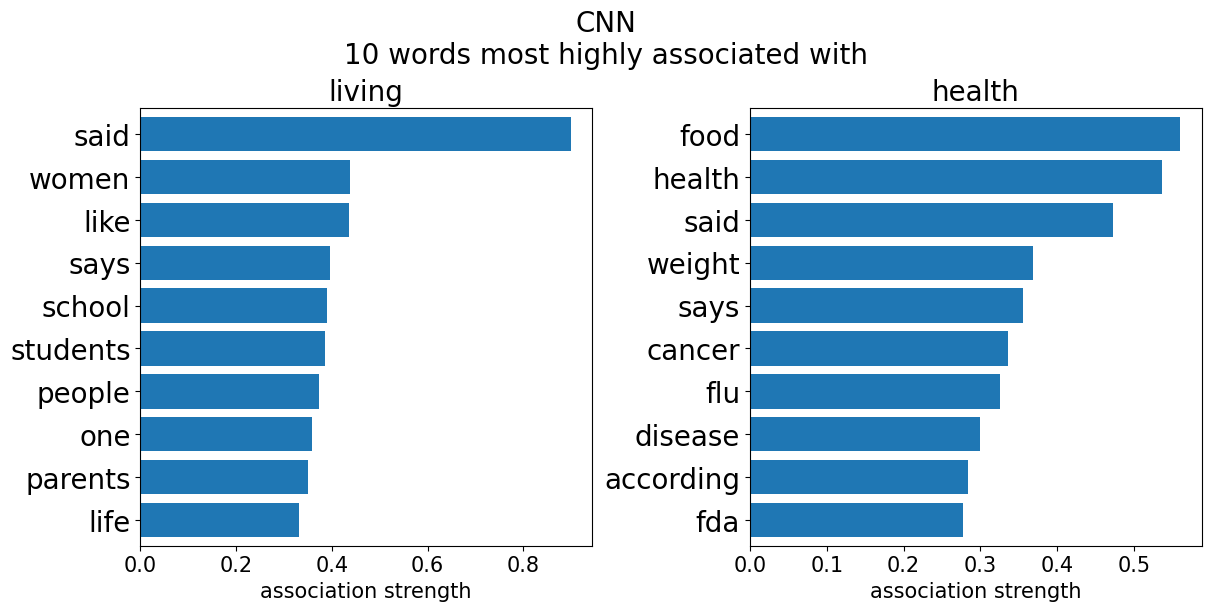

In [139]:
top_ten_words_plot(res_table=res_table, pipe=pipe, upper_title='CNN')

Now, apart from the words `said` and `says` that should have been ignored during text processing, the difference is clear.